In [1]:
#### Reference paper https://arxiv.org/abs/1808.08219




import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
import scipy.optimize as optimize
from scipy.optimize import root_scalar
from adaptive_integrator import integrate
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "serif"
})

import warnings
warnings.filterwarnings('ignore', 'The iteration is not making good progress')


π = np.pi
Ω_cdm = 0.85
G = 6.67e-11                # in units of m^3⋅kg^−1⋅s^−2
t_i = 2.358e5                # in units of seconds
t_eq = 1.5923e12            # in units of seconds
ρ_eq = 2.1548e-16          # in units of kg m^-3
M_solar = 1.989e30        # in units of kg
c = 3e8                 #in units of m/s
A = 1.495e11                 # Astronomical unit
pc = 3.085e16               # in unist of meter. 
yr = 3.154e7              # in units of seconds
a_eq = 2.9374e-4

hbar = 1.0545718e-34        # reduced Planck constant in unkits of J.s
eV = 1.60218e-19               #in units of J
eV_to_kg = 1.7826e-36             #in units of kg
m_FDM_eV = 1e-22     #in units of eV/c²
m_FDM = m_FDM_eV * eV_to_kg      # Mass of FDM boson in units of kg


 
def j_fdm(t, y, gamma):
    r, dydtau = y
    dydtau2 = (2 * gamma - gamma**2)/(4 * (r**3)) - (1/(r**2)) - r/(4 * (t**2))
    return [dydtau, dydtau2]


def j_cdm(t, y):
    r, dydtau = y
    dydtau2 =  - 1/(r**2) - r/(4 * (t**2))
    return [dydtau, dydtau2]


# Full analytic turnaround radius
def r_turnaround_full(tau, gamma): 
    def expression(y_ta):
        return y_ta**4 - 4 * y_ta * (tau**2) + (2 * gamma - gamma**2) * (tau**2)
    factor = 0.635 * (1 + 0.01 * np.log10(1 + gamma))
    #print(factor)
    r_ta_initial = factor * (8 * (tau**2))**(1/3)
    sol = optimize.fsolve(expression, r_ta_initial, xtol=1e-10)[0]
    return sol





# Event function for maximum (dy/dtau = 0)
def event_y_max(t, y, *args):
    return y[1]  # Detect when velocity (dy/dtau) is zero
event_y_max.terminal = False  # Do not stop integration here
event_y_max.direction = -1    # Detect decreasing slope (peak reached)
# Event function for minimum (dy/dtau = 0 after y_max)
def event_y_min(t, y, *args):
    return y[1]  # Detect when velocity (dy/dtau) is zero
event_y_min.terminal = True   # Stop integration here
event_y_min.direction = 1     # Detect increasing slope (trough reached)




def y(gamma):
    solutions = []
    turnaround_points = []
    for y_i in yi_values:
        v_i = y_i / (2 * tau_i)
        y0 = [y_i, v_i]
        tau_arr = np.geomspace(tau_i, tau_f, 10000)
        sol = solve_ivp(j_fdm, [tau_i, tau_f], y0, args=(gamma,), 
                        method='RK45', t_eval=tau_arr, 
                        rtol=1e-5, atol=1e-5, events=[event_y_max, event_y_min])
        solutions.append((sol.t, sol.y[0], y_i))
        if sol.t_events[0].size > 0:
            tauta_numerical = sol.t_events[0][0]
            yta_numerical = sol.y_events[0][0][0]
            #yta_analytic = r_turnaround_full(tauta_numerical, gamma)
            #print( "gamma =", '%0.1e'%gamma, ",", "y_i =", '%0.4e'%y_i, ",",  "tau_ta_numerical =", '%0.4e'%tauta_numerical, ",", "yta_numerical =", '%0.4e'%yta_numerical, ",", "yta_analytic =", '%0.4e'%yta_analytic)
            turnaround_points.append((y_i, tauta_numerical, yta_numerical))  

    return solutions, turnaround_points

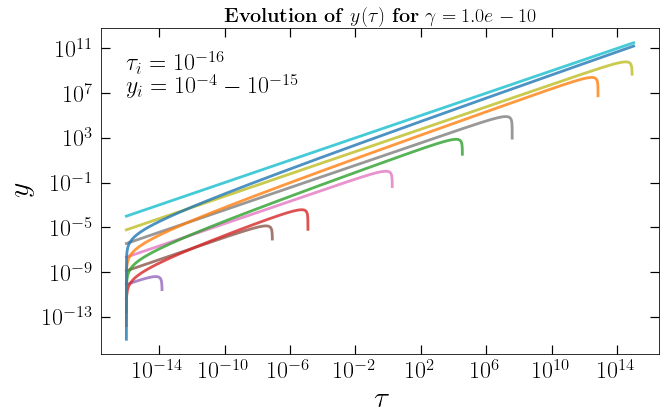

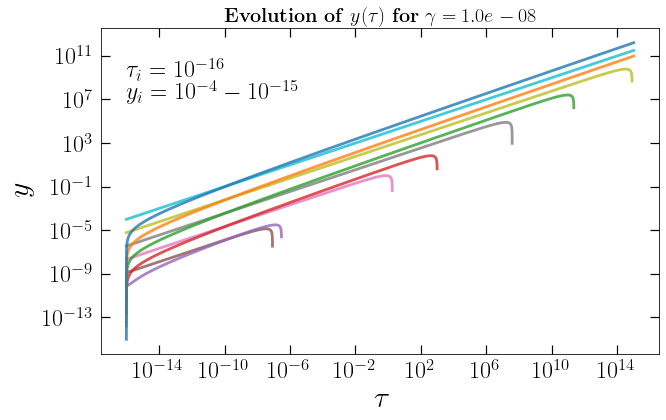

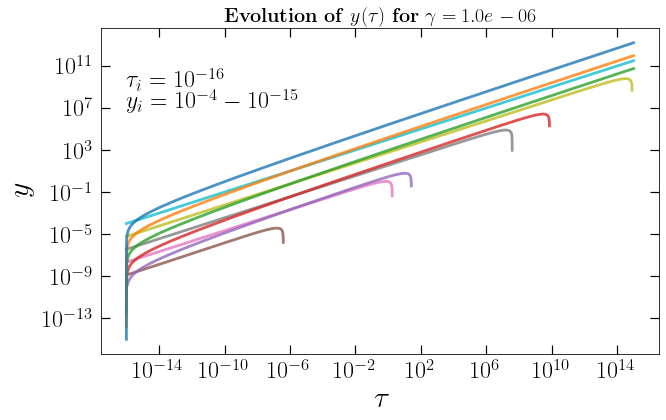

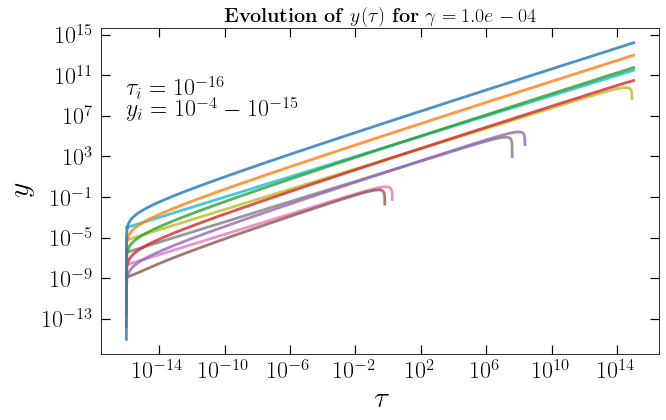

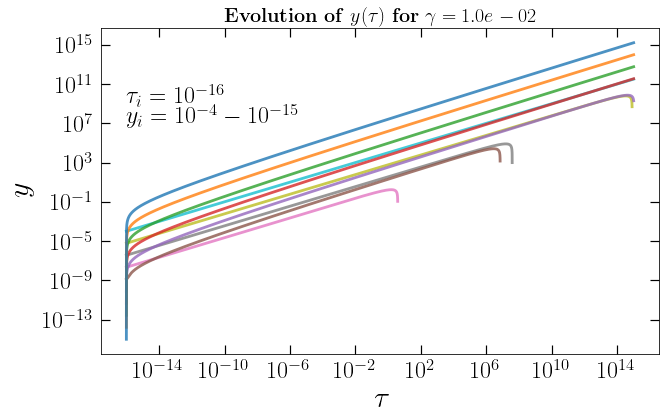

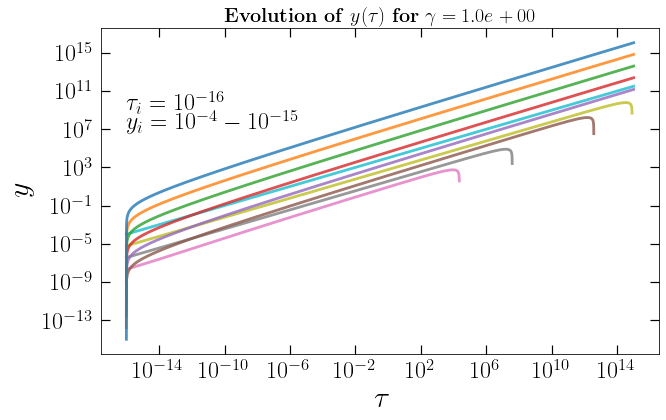

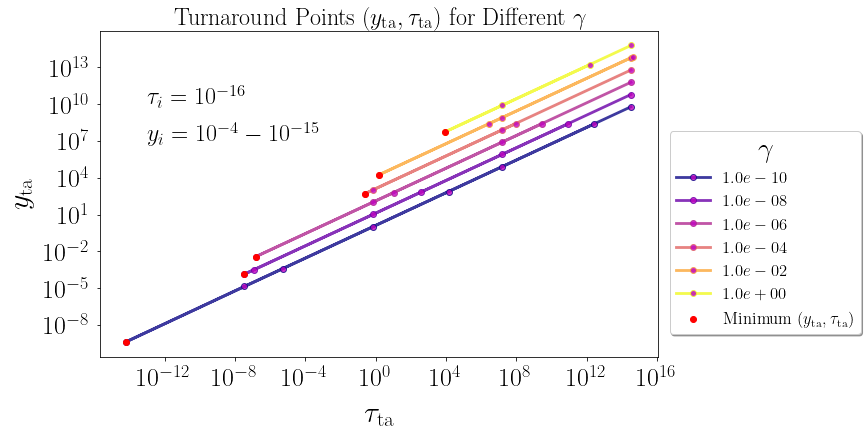

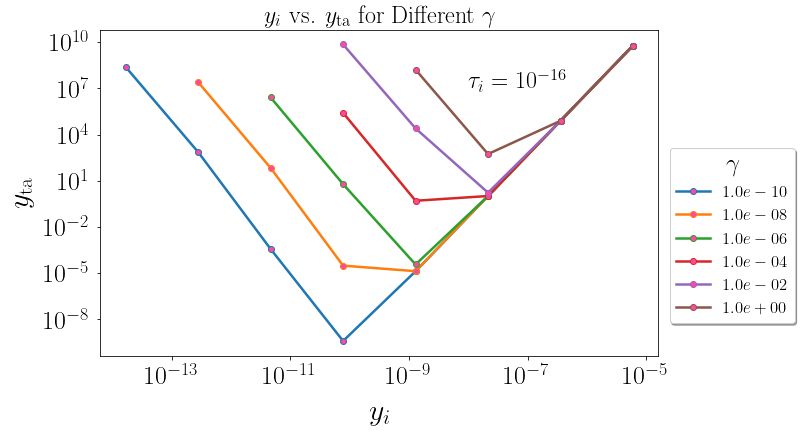

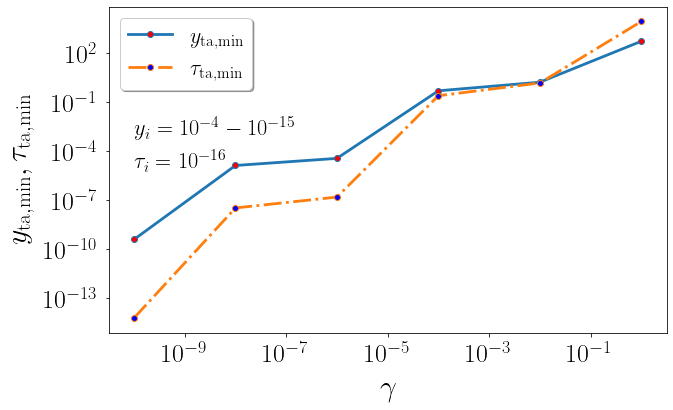

Minimum values of the turnraound points for each gamma :-
Gamma: 1.0e-10, Y_i: 7.7426e-11, Tau_ta_numerical: 6.2100e-15, Y_ta_numerical: 4.0057e-10, Y_ta_analytical: 5.1848e-10
Gamma: 1.0e-08, Y_i: 1.2915e-09, Tau_ta_numerical: 3.4184e-08, Y_ta_numerical: 1.3644e-05, Y_ta_analytical: 1.6718e-05
Gamma: 1.0e-06, Y_i: 1.2915e-09, Tau_ta_numerical: 1.5814e-07, Y_ta_numerical: 3.7167e-05, Y_ta_analytical: 4.6252e-05
Gamma: 1.0e-04, Y_i: 1.2915e-09, Tau_ta_numerical: 2.5585e-01, Y_ta_numerical: 5.1205e-01, Y_ta_analytical: 6.3974e-01
Gamma: 1.0e-02, Y_i: 2.1544e-08, Tau_ta_numerical: 1.5426e+00, Y_ta_numerical: 1.7205e+00, Y_ta_analytical: 2.1177e+00
Gamma: 1.0e+00, Y_i: 2.1544e-08, Tau_ta_numerical: 9.0309e+03, Y_ta_numerical: 5.5363e+02, Y_ta_analytical: 6.8832e+02


In [2]:
# Now, we want to verify that for a given value of gamma,
# whether the minimum values of yta_numerical and tau_ta_numerical are properly 
# identified or not.
# This will verify the validity of y_ta_min vs y_i plots.



gamma_values = np.geomspace(1e-10, 1, 6) 
yi_values = np.geomspace(1e-4, 1e-15, 10)  
tau_i, tau_f = 1e-16, 1e15 
colors = ['C9','C8','C7','C6', 'C5', 'C4', 'C3', 'C2', 'C1', 'C0']  



gamma_results = {gamma: y(gamma) for gamma in gamma_values}
min_turnaround_pts = [(gamma, *min(gamma_results[gamma][1], key=lambda x: x[1])) 
                      for gamma in gamma_values]
gamma_colors = plt.cm.viridis(np.linspace(0, 1, len(gamma_values)))
turnaround_colors = plt.cm.plasma(np.linspace(0, 1, len(gamma_values)))  



#plotting y vs tau for different values of gamma, each with different values of y_i
for i, (gamma, (solutions, _)) in enumerate(gamma_results.items()):
    fig1, ax1 = plt.subplots(figsize=(10, 6))
    plt.rc('lines', linewidth = 2.8)
    plt.rcParams['font.family'] = 'serif'
    plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
    plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')

    for j, ((tau_vals, y_vals, y_i), color) in enumerate(zip(solutions, colors * (len(solutions) // len(colors) + 1))):
        ax1.loglog(tau_vals, y_vals, color=color, alpha=0.8, label=f"${y_i:.1e}$")
    
    plt.text(tau_i, 1e9, r'$\tau_i = 10^{-16}$', fontsize=24)
    plt.text(tau_i, 1e7, r'$y_i = 10^{-4} - 10^{-15}$', fontsize=24)
    ax1.tick_params(axis='x', pad=6.9)
    ax1.tick_params(axis='y', pad=6.9)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.xlabel(r'$\tau$', fontsize=30)
    plt.ylabel(r'$y$', fontsize=30, labelpad=9)
    ax1.set_title(rf'$\mathbf{{Evolution\ of\ }} y(\tau) \mathbf{{\ for\ }} \gamma={gamma:.1e}$', fontsize=20)
    #ax1.legend(prop={'size':13.7}, loc=(1.02, 0.1), shadow=True, title='$y_{i}$', title_fontsize=26,
              # facecolor='white', fontsize=12)
    plt.savefig(f"y4_evolution3_gamma_{gamma:.1e}.pdf",  bbox_inches='tight')
    plt.show()



    
    
#plotting (y_ta, tau_ta) points for different values of gamma (each with different values of y_i)
fig2, ax2 = plt.subplots(figsize=(10, 6))
for i, (gamma, (_, turnaround_points)) in enumerate(gamma_results.items()): 
    yi_ta, tau_ta, y_ta = zip(*turnaround_points)  
    y_ta_scaled = [y * 10**i for y in y_ta] 
    ax2.loglog(tau_ta, y_ta_scaled, color=turnaround_colors[i], label=f"${gamma:.1e}$", marker='o', markersize=6, markerfacecolor='m', alpha=0.8)
    
gamma_arr, min_yi_arr,  min_tau_arr, min_y_arr = zip(*min_turnaround_pts)
min_y_arr_scaled = [y * 10**i for i, y in enumerate(min_y_arr)]
ax2.scatter(min_tau_arr, min_y_arr_scaled, color='r', zorder=10, label="Minimum $( y_\\mathrm{ta}, \\tau_\\mathrm{ta})$")

plt.text(1e-13, 1e7, '$y_i = 10^{-4} - 10^{-15}$', fontsize=24)
plt.text(1e-13, 1e10, r'$\tau_i = 10^{-16}$', fontsize=24)
ax2.tick_params(axis='x', pad=6.9)
ax2.tick_params(axis='y', pad=6.9)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
ax2.set_xlabel(r'$\tau_\mathrm{ta}$', fontsize=30, labelpad=10)
ax2.set_ylabel(r'$y_\mathrm{ta}$', fontsize=30, labelpad=10)
ax2.set_title(r'Turnaround Points $(y_\mathrm{ta}, \tau_\mathrm{ta})$ for Different $\gamma$', fontsize=24)
ax2.legend(prop={'size':16.7}, loc=(1.02, 0.07), shadow=True, title=r'$\gamma$', title_fontsize=28,
           facecolor='white', fontsize=12)
plt.savefig("turnaround_points4.pdf", bbox_inches='tight')
plt.show()

#plotting (y_ta, y_i) points for different values of gamma 
fig3, ax3 = plt.subplots(figsize=(10, 6))
for i, (gamma, (_, turnaround_points)) in enumerate(gamma_results.items()):
    yi_ta, tau_ta , y_ta = zip(*turnaround_points)
    ax3.loglog(yi_ta, y_ta, marker='o', markersize=6, markerfacecolor='#fd49a0', linestyle='-', linewidth=2.5, label=f"${gamma:.1e}$")

    
#plt.text(1e-8, 1e9, '$y_i = 10^{-4} - 10^{-15}$', fontsize=24)
plt.text(1e-8, 1e7, r'$\tau_i = 10^{-16}$', fontsize=24)
ax3.tick_params(axis='x', pad=6.9)
ax3.tick_params(axis='y', pad=6.9)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
ax3.set_xlabel(r'$y_i$', fontsize=30, labelpad=10)
ax3.set_ylabel(r'$y_\mathrm{ta}$', fontsize=30, labelpad=10)
ax3.set_title(r'$y_i$ vs. $y_\mathrm{ta}$ for Different $\gamma$', fontsize=24)
ax3.legend(prop={'size':16.7}, loc=(1.02, 0.1), shadow=True, title=r'$\gamma$', title_fontsize=25,
           facecolor='white', fontsize=12)
plt.savefig("yi_vs_yta4.pdf", bbox_inches='tight')
plt.show()



# y_ta_min, tau_ta_min vs gamma
fig4, ax4 = plt.subplots(figsize=(10, 6))
gamma_arr, min_yi_arr,  min_tau_arr, min_y_arr = zip(*min_turnaround_pts)

ax4.loglog(gamma_arr, min_y_arr, marker='o', markersize=6, markerfacecolor='r',ls = '-')
ax4.loglog(gamma_arr, min_tau_arr,  marker='o', markersize=6, markerfacecolor='b', ls = '-.')

plt.text(1e-10, 1e-3, '$y_i = 10^{-4} - 10^{-15}$', fontsize=22.5)
plt.text(1e-10, 1e-5, r'$\tau_i = 10^{-16}$', fontsize=22.5)



ax4.tick_params(axis='x', pad=6.9)
ax4.tick_params(axis='y', pad=6.9)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
ax4.set_xlabel('$\gamma$', fontsize=30, labelpad=10)
ax4.set_ylabel(r'$y_\mathrm{ta, min},  \tau_\mathrm{ta, min}$', fontsize=30, labelpad=10)
ax4.legend([r"$y_\mathrm{ta, min}$", r"$\tau_\mathrm{ta, min}$"], prop={'size':22}, loc='upper left', shadow=True,  title_fontsize=18,
           facecolor='white', fontsize=12)

plt.savefig("yta_min_vs_gamma4.pdf", bbox_inches='tight')
plt.show()

gamma_arr, min_yi_arr,  min_tau_arr, min_y_arr = zip(*min_turnaround_pts)
yta_analytical_arr = np.zeros(len(gamma_arr))
for i, (gamma, min_tau) in enumerate(zip(gamma_arr, min_tau_arr)):
    yta_analytical_arr[i] = r_turnaround_full(min_tau, gamma)

min_turnaround_pts = list(zip(gamma_arr, min_yi_arr, min_tau_arr, min_y_arr, yta_analytical_arr))
print('Minimum values of the turnraound points for each gamma :-')
for gamma, min_yi, min_tau, min_y, y_ta_ana in min_turnaround_pts:
    print(f"Gamma: {gamma:.1e}, Y_i: {min_yi:.4e}, Tau_ta_numerical: {min_tau:.4e}, Y_ta_numerical: {min_y:.4e}, Y_ta_analytical: {y_ta_ana:.4e}")

In [ ]:
# with spacings y_i = [0.1 y_i_min_ref , yi_min_ref, 0.2 yi_min_ref]

y_i = 7.7426e-12 , tau_ta_numerical = 1.8967e-08 , yta_numerical = 8.8941e-06 , yta_analytic = 1.1290e-05
y_i = 7.7426e-11 , tau_ta_numerical = 6.2099e-15 , yta_numerical = 4.0056e-10 , yta_analytic = 5.1848e-10
y_i = 1.5485e-11 , tau_ta_numerical = 1.2597e-13 , yta_numerical = 2.9295e-09 , yta_analytic = 3.9722e-09


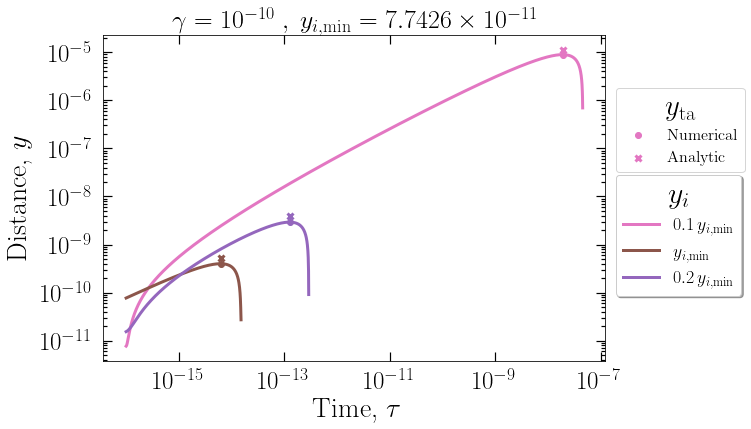

In [15]:
gamma = 1e-10
y_i_ref = 7.7426e-11
tau_i, tau_f = 1e-16, 1e15
gamma_values = np.geomspace(1e-10, 1, 5)  
yi_arr = np.array([0.1*y_i_ref, y_i_ref, 0.2*y_i_ref])


fig, ax = plt.subplots(1, figsize = (9, 6))
plt.rc('lines', linewidth = 3)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')






colors = ['C6', 'C5', 'C4', 'C3', 'C2', 'C1', 'C0']
marker_handles = []
for i, (y_i, color) in enumerate(zip(yi_arr, colors)):
    v_i = y_i/(2 * tau_i) 
    y0 = [y_i, v_i]
    tau_arr = np.geomspace(tau_i, tau_f, 10000) 

    
    sol_fdm = solve_ivp(j_fdm, [tau_i, tau_f], y0, args=(gamma,), t_eval=tau_arr, method='RK45',
        rtol=1e-5, atol=1e-5, events=[event_y_max, event_y_min])

    
    ax.loglog(sol_fdm.t, sol_fdm.y[0], color=color) #, label=f' ${y_i:.1e}$'

    
    if len(sol_fdm.t_events[0]) > 0: 
        tauta_numerical = sol_fdm.t_events[0][0]
        yta_numerical = sol_fdm.y_events[0][0][0]
        yta_analytic = r_turnaround_full(tauta_numerical, gamma)
        print( "y_i =", '%0.4e'%y_i , ",",  "tau_ta_numerical =", '%0.4e'%tauta_numerical, ",", "yta_numerical =", '%0.4e'%yta_numerical, ",", "yta_analytic =", '%0.4e'%yta_analytic)
            
        yta_numerical_marker = ax.scatter(tauta_numerical, yta_numerical,color=color, zorder=1  )
        yta_analytic_marker = ax.scatter(tauta_numerical, yta_analytic, color=color,  marker='x',  zorder=9)
        if i == 0:
            marker_handles.append((yta_numerical_marker, "Numerical "))
            marker_handles.append((yta_analytic_marker, "Analytic"))

if len(marker_handles) == 2:  
    legend1 = plt.legend(
        handles=[marker_handles[0][0], marker_handles[1][0]],
        labels=[marker_handles[0][1], marker_handles[1][1]],prop={'size':16.2},
        loc=(1.02, 0.58), title=r'$y_\mathrm{ta}$', title_fontsize= 29, fontsize=12)
    ax.add_artist(legend1)


lines = ax.get_lines()
legend2 = plt.legend([lines[i] for i in [0, 1, 2]], [r"$0.1 \,  y_{i, \mathrm{min}}$", r"$y_{i, \mathrm{min}}$", 
                      r"$0.2 \, y_{i, \mathrm{min}}$"], prop={'size':18}, 
                     loc=(1.02, 0.2), shadow=True, title='$y_{i}$', title_fontsize= 30,
    facecolor='white', fontsize=12)


ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)


#plt.text(tau_i, 1e-4, r'$\gamma = 3.6\times 10^{-5}$', fontsize = 25)
#plt.text(tau_i, 1e-6, r'$\tau_i = 10^{-28}$', fontsize = 25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel(r'Time, $\tau$', fontsize=28)
plt.ylabel('Distance, $y$', fontsize=28, labelpad=9)
plt.title(r'$\gamma = 10^{-10}\; , \; y_{i, \mathrm{min}} = 7.7426 \times 10^{-11}$', fontsize= 26)
plt.savefig('yta_min1.pdf', bbox_inches='tight')

plt.show()

y_i = 1.2915e-10 , tau_ta_numerical = 9.2506e-10 , yta_numerical = 1.1780e-06 , yta_analytic = 1.5054e-06
y_i = 1.2915e-09 , tau_ta_numerical = 3.4176e-08 , yta_numerical = 1.3642e-05 , yta_analytic = 1.6716e-05
y_i = 2.5830e-10 , tau_ta_numerical = 2.6482e-11 , yta_numerical = 1.0925e-07 , yta_analytic = 1.3932e-07


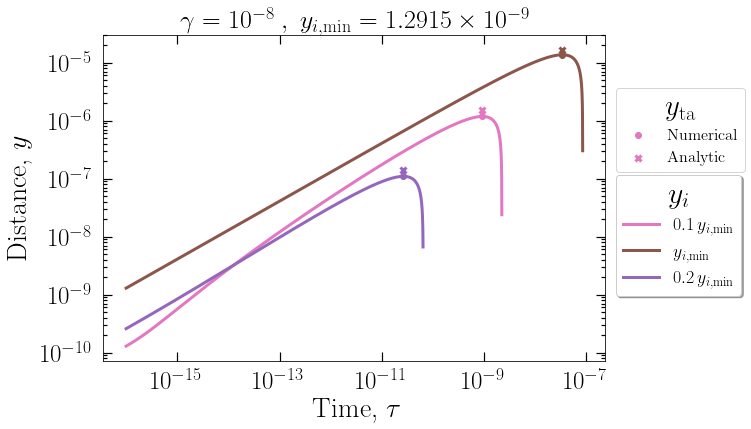

In [14]:
gamma = 1.0e-08
y_i_ref = 1.2915e-09
tau_i, tau_f = 1e-16, 1e15
gamma_values = np.geomspace(1e-10, 1, 5)  
yi_arr = np.array([0.1*y_i_ref, y_i_ref, 0.2*y_i_ref])


fig, ax = plt.subplots(1, figsize = (9, 6))
plt.rc('lines', linewidth = 3)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')






colors = ['C6', 'C5', 'C4', 'C3', 'C2', 'C1', 'C0']
marker_handles = []
for i, (y_i, color) in enumerate(zip(yi_arr, colors)):
    v_i = y_i/(2 * tau_i) 
    y0 = [y_i, v_i]
    tau_arr = np.geomspace(tau_i, tau_f, 10000) 

    
    sol_fdm = solve_ivp(j_fdm, [tau_i, tau_f], y0, args=(gamma,), t_eval=tau_arr, method='RK45',
        rtol=1e-5, atol=1e-5, events=[event_y_max, event_y_min])

    
    ax.loglog(sol_fdm.t, sol_fdm.y[0], color=color) #, label=f' ${y_i:.1e}$'

    
    if len(sol_fdm.t_events[0]) > 0: 
        tauta_numerical = sol_fdm.t_events[0][0]
        yta_numerical = sol_fdm.y_events[0][0][0]
        yta_analytic = r_turnaround_full(tauta_numerical, gamma)
        print( "y_i =", '%0.4e'%y_i , ",",  "tau_ta_numerical =", '%0.4e'%tauta_numerical, ",", "yta_numerical =", '%0.4e'%yta_numerical, ",", "yta_analytic =", '%0.4e'%yta_analytic)
            
        yta_numerical_marker = ax.scatter(tauta_numerical, yta_numerical,color=color, zorder=1  )
        yta_analytic_marker = ax.scatter(tauta_numerical, yta_analytic, color=color,  marker='x',  zorder=9)
        if i == 0:
            marker_handles.append((yta_numerical_marker, "Numerical "))
            marker_handles.append((yta_analytic_marker, "Analytic"))

if len(marker_handles) == 2:  
    legend1 = plt.legend(
        handles=[marker_handles[0][0], marker_handles[1][0]],
        labels=[marker_handles[0][1], marker_handles[1][1]],prop={'size':16.2},
        loc=(1.02, 0.58), title=r'$y_\mathrm{ta}$', title_fontsize= 29, fontsize=12)
    ax.add_artist(legend1)


lines = ax.get_lines()
legend2 = plt.legend([lines[i] for i in [0, 1, 2]], [r"$0.1 \,  y_{i, \mathrm{min}}$", r"$y_{i, \mathrm{min}}$", 
                      r"$0.2 \, y_{i, \mathrm{min}}$"], prop={'size':18}, 
                     loc=(1.02, 0.2), shadow=True, title='$y_{i}$', title_fontsize= 30,
    facecolor='white', fontsize=12)

ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)


#plt.text(tau_i, 1e-4, r'$\gamma = 3.6\times 10^{-5}$', fontsize = 25)
#plt.text(tau_i, 1e-6, r'$\tau_i = 10^{-28}$', fontsize = 25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel(r'Time, $\tau$', fontsize=28)
plt.ylabel('Distance, $y$', fontsize=28, labelpad=9)
plt.title(r'$\gamma = 10^{-8}\; , \; y_{i, \mathrm{min}} = 1.2915 \times 10^{-9}$', fontsize= 26)
plt.savefig('yta_min2.pdf', bbox_inches='tight')

plt.show()

y_i = 1.2915e-10 , tau_ta_numerical = 2.5574e-01 , yta_numerical = 5.1188e-01 , yta_analytic = 6.3956e-01
y_i = 1.2915e-09 , tau_ta_numerical = 1.5813e-07 , yta_numerical = 3.7166e-05 , yta_analytic = 4.6250e-05
y_i = 2.5830e-10 , tau_ta_numerical = 1.3897e-03 , yta_numerical = 1.5770e-02 , yta_analytic = 1.9768e-02


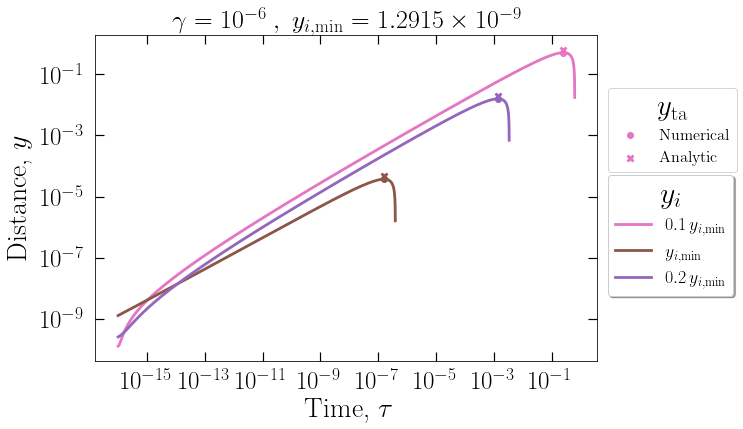

In [13]:
gamma = 1.0e-06
y_i_ref = 1.2915e-09
tau_i, tau_f = 1e-16, 1e15
gamma_values = np.geomspace(1e-10, 1, 5)  
yi_arr = np.array([0.1*y_i_ref, y_i_ref, 0.2*y_i_ref])


fig, ax = plt.subplots(1, figsize = (9, 6))
plt.rc('lines', linewidth = 2.8)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')






colors = ['C6', 'C5', 'C4', 'C3', 'C2', 'C1', 'C0']
marker_handles = []
for i, (y_i, color) in enumerate(zip(yi_arr, colors)):
    v_i = y_i/(2 * tau_i) 
    y0 = [y_i, v_i]
    tau_arr = np.geomspace(tau_i, tau_f, 10000) 

    
    sol_fdm = solve_ivp(j_fdm, [tau_i, tau_f], y0, args=(gamma,), t_eval=tau_arr, method='RK45',
        rtol=1e-5, atol=1e-5, events=[event_y_max, event_y_min])

    
    ax.loglog(sol_fdm.t, sol_fdm.y[0], color=color) #, label=f' ${y_i:.1e}$'

    
    if len(sol_fdm.t_events[0]) > 0: 
        tauta_numerical = sol_fdm.t_events[0][0]
        yta_numerical = sol_fdm.y_events[0][0][0]
        yta_analytic = r_turnaround_full(tauta_numerical, gamma)
        print( "y_i =", '%0.4e'%y_i , ",",  "tau_ta_numerical =", '%0.4e'%tauta_numerical, ",", "yta_numerical =", '%0.4e'%yta_numerical, ",", "yta_analytic =", '%0.4e'%yta_analytic)
            
        yta_numerical_marker = ax.scatter(tauta_numerical, yta_numerical,color=color, zorder=1  )
        yta_analytic_marker = ax.scatter(tauta_numerical, yta_analytic, color=color,  marker='x',  zorder=9)
        if i == 0:
            marker_handles.append((yta_numerical_marker, "Numerical "))
            marker_handles.append((yta_analytic_marker, "Analytic"))

if len(marker_handles) == 2:  
    legend1 = plt.legend(
        handles=[marker_handles[0][0], marker_handles[1][0]],
        labels=[marker_handles[0][1], marker_handles[1][1]],prop={'size':16.2},
        loc=(1.02, 0.58), title=r'$y_\mathrm{ta}$', title_fontsize= 29, fontsize=12)
    ax.add_artist(legend1)


lines = ax.get_lines()
legend2 = plt.legend([lines[i] for i in [0, 1, 2]], [r"$0.1 \,  y_{i, \mathrm{min}}$", r"$y_{i, \mathrm{min}}$", 
                      r"$0.2 \, y_{i, \mathrm{min}}$"], prop={'size':18}, 
                     loc=(1.02, 0.2), shadow=True, title='$y_{i}$', title_fontsize= 30,
    facecolor='white', fontsize=12)

ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)


#plt.text(tau_i, 1e-4, r'$\gamma = 3.6\times 10^{-5}$', fontsize = 25)
#plt.text(tau_i, 1e-6, r'$\tau_i = 10^{-28}$', fontsize = 25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel(r'Time, $\tau$', fontsize=28)
plt.ylabel('Distance, $y$', fontsize=28, labelpad=9)
plt.title(r'$\gamma = 10^{-6}\; , \; y_{i, \mathrm{min}} = 1.2915 \times 10^{-9}$', fontsize= 26)
plt.savefig('yta_min3.pdf', bbox_inches='tight')
plt.show()

y_i = 1.2915e-10 , tau_ta_numerical = 2.8722e+06 , yta_numerical = 2.5828e+04 , yta_analytic = 3.2075e+04
y_i = 1.2915e-09 , tau_ta_numerical = 2.5592e-01 , yta_numerical = 5.1215e-01 , yta_analytic = 6.3985e-01
y_i = 2.5830e-10 , tau_ta_numerical = 2.4316e+04 , yta_numerical = 1.0714e+03 , yta_analytic = 1.3323e+03


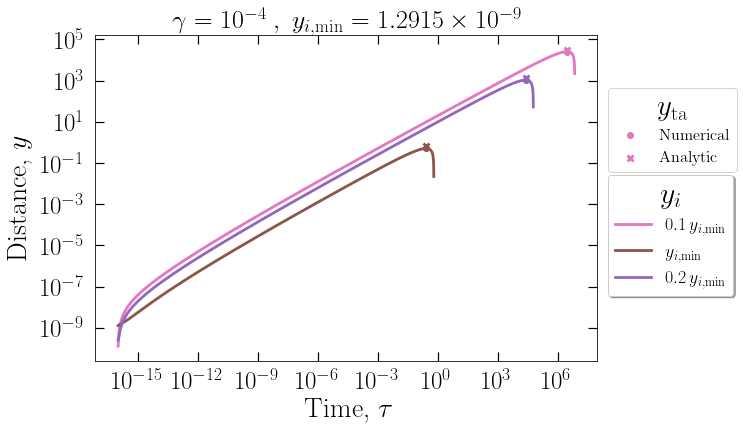

In [12]:
gamma = 1.0e-04
y_i_ref = 1.2915e-09
tau_i, tau_f = 1e-16, 1e15
gamma_values = np.geomspace(1e-10, 1, 5)  
yi_arr = np.array([0.1*y_i_ref, y_i_ref, 0.2*y_i_ref])


fig, ax = plt.subplots(1, figsize = (9, 6))
plt.rc('lines', linewidth = 2.8)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')






colors = ['C6', 'C5', 'C4', 'C3', 'C2', 'C1', 'C0']
marker_handles = []
for i, (y_i, color) in enumerate(zip(yi_arr, colors)):
    v_i = y_i/(2 * tau_i) 
    y0 = [y_i, v_i]
    tau_arr = np.geomspace(tau_i, tau_f, 10000) 

    
    sol_fdm = solve_ivp(j_fdm, [tau_i, tau_f], y0, args=(gamma,), t_eval=tau_arr, method='RK45',
        rtol=1e-5, atol=1e-5, events=[event_y_max, event_y_min])

    
    ax.loglog(sol_fdm.t, sol_fdm.y[0], color=color) #, label=f' ${y_i:.1e}$'

    
    if len(sol_fdm.t_events[0]) > 0: 
        tauta_numerical = sol_fdm.t_events[0][0]
        yta_numerical = sol_fdm.y_events[0][0][0]
        yta_analytic = r_turnaround_full(tauta_numerical, gamma)
        print( "y_i =", '%0.4e'%y_i , ",",  "tau_ta_numerical =", '%0.4e'%tauta_numerical, ",", "yta_numerical =", '%0.4e'%yta_numerical, ",", "yta_analytic =", '%0.4e'%yta_analytic)
            
        yta_numerical_marker = ax.scatter(tauta_numerical, yta_numerical,color=color, zorder=1  )
        yta_analytic_marker = ax.scatter(tauta_numerical, yta_analytic, color=color,  marker='x',  zorder=9)
        if i == 0:
            marker_handles.append((yta_numerical_marker, "Numerical "))
            marker_handles.append((yta_analytic_marker, "Analytic"))

if len(marker_handles) == 2:  
    legend1 = plt.legend(
        handles=[marker_handles[0][0], marker_handles[1][0]],
        labels=[marker_handles[0][1], marker_handles[1][1]],prop={'size':16.2},
        loc=(1.02, 0.58), title=r'$y_\mathrm{ta}$', title_fontsize= 29, fontsize=12)
    ax.add_artist(legend1)


lines = ax.get_lines()
legend2 = plt.legend([lines[i] for i in [0, 1, 2]], [r"$0.1 \,  y_{i, \mathrm{min}}$", r"$y_{i, \mathrm{min}}$", 
                      r"$0.2 \, y_{i, \mathrm{min}}$"], prop={'size':18}, 
                     loc=(1.02, 0.2), shadow=True, title='$y_{i}$', title_fontsize= 30,
    facecolor='white', fontsize=12)

ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)


#plt.text(tau_i, 1e-4, r'$\gamma = 3.6\times 10^{-5}$', fontsize = 25)
#plt.text(tau_i, 1e-6, r'$\tau_i = 10^{-28}$', fontsize = 25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel(r'Time, $\tau$', fontsize=28)
plt.ylabel('Distance, $y$', fontsize=28, labelpad=9)
plt.title(r'$\gamma = 10^{-4}\; , \; y_{i, \mathrm{min}} = 1.2915 \times 10^{-9}$', fontsize= 26)
plt.savefig('yta_min4.pdf', bbox_inches='tight')

plt.show()

y_i = 2.1544e-09 , tau_ta_numerical = 8.4015e+04 , yta_numerical = 2.4495e+03 , yta_analytic = 3.0450e+03
y_i = 2.1544e-08 , tau_ta_numerical = 1.5426e+00 , yta_numerical = 1.7204e+00 , yta_analytic = 2.1176e+00
y_i = 4.3088e-09 , tau_ta_numerical = 6.7482e+02 , yta_numerical = 9.8092e+01 , yta_analytic = 1.2213e+02


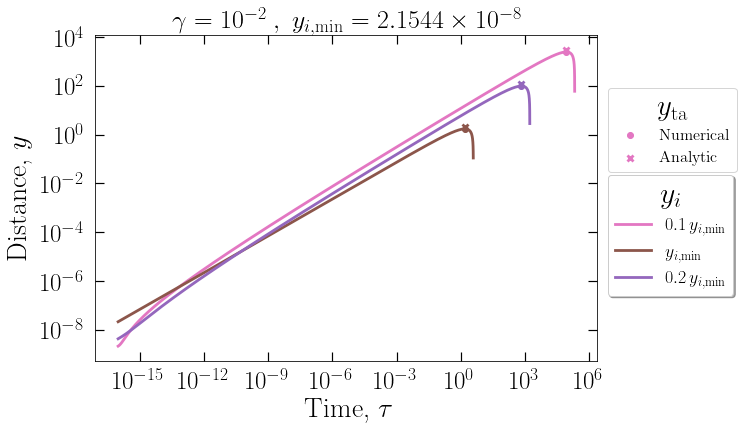

In [11]:
gamma = 1.0e-02 
y_i_ref = 2.1544e-08
tau_i, tau_f = 1e-16, 1e15
gamma_values = np.geomspace(1e-10, 1, 5)  
yi_arr = np.array([0.1*y_i_ref, y_i_ref, 0.2*y_i_ref])


fig, ax = plt.subplots(1, figsize = (9, 6))
plt.rc('lines', linewidth = 2.8)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')






colors = ['C6', 'C5', 'C4', 'C3', 'C2', 'C1', 'C0']
marker_handles = []
for i, (y_i, color) in enumerate(zip(yi_arr, colors)):
    v_i = y_i/(2 * tau_i) 
    y0 = [y_i, v_i]
    tau_arr = np.geomspace(tau_i, tau_f, 10000) 

    
    sol_fdm = solve_ivp(j_fdm, [tau_i, tau_f], y0, args=(gamma,), t_eval=tau_arr, method='RK45',
        rtol=1e-5, atol=1e-5, events=[event_y_max, event_y_min])

    
    ax.loglog(sol_fdm.t, sol_fdm.y[0], color=color) #, label=f' ${y_i:.1e}$'

    
    if len(sol_fdm.t_events[0]) > 0: 
        tauta_numerical = sol_fdm.t_events[0][0]
        yta_numerical = sol_fdm.y_events[0][0][0]
        yta_analytic = r_turnaround_full(tauta_numerical, gamma)
        print( "y_i =", '%0.4e'%y_i , ",",  "tau_ta_numerical =", '%0.4e'%tauta_numerical, ",", "yta_numerical =", '%0.4e'%yta_numerical, ",", "yta_analytic =", '%0.4e'%yta_analytic)
            
        yta_numerical_marker = ax.scatter(tauta_numerical, yta_numerical,color=color, zorder=1  )
        yta_analytic_marker = ax.scatter(tauta_numerical, yta_analytic, color=color,  marker='x',  zorder=9)
        if i == 0:
            marker_handles.append((yta_numerical_marker, "Numerical "))
            marker_handles.append((yta_analytic_marker, "Analytic"))

if len(marker_handles) == 2:  
    legend1 = plt.legend(
        handles=[marker_handles[0][0], marker_handles[1][0]],
        labels=[marker_handles[0][1], marker_handles[1][1]],prop={'size':16.2},
        loc=(1.02, 0.58), title=r'$y_\mathrm{ta}$', title_fontsize= 29, fontsize=12)
    ax.add_artist(legend1)


lines = ax.get_lines()
legend2 = plt.legend([lines[i] for i in [0, 1, 2]], [r"$0.1 \,  y_{i, \mathrm{min}}$", r"$y_{i, \mathrm{min}}$", 
                      r"$0.2 \, y_{i, \mathrm{min}}$"], prop={'size':18}, 
                     loc=(1.02, 0.2), shadow=True, title='$y_{i}$', title_fontsize= 30,
    facecolor='white', fontsize=12)

ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)


#plt.text(tau_i, 1e-4, r'$\gamma = 3.6\times 10^{-5}$', fontsize = 25)
#plt.text(tau_i, 1e-6, r'$\tau_i = 10^{-28}$', fontsize = 25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel(r'Time, $\tau$', fontsize=28)
plt.ylabel('Distance, $y$', fontsize=28, labelpad=9)
plt.title(r'$\gamma = 10^{-2}\; , \; y_{i, \mathrm{min}} = 2.1544\times 10^{-8}$', fontsize= 26)
plt.savefig('yta_min5.pdf', bbox_inches='tight')

plt.show()

y_i = 2.1544e-09 , tau_ta_numerical = 4.9228e+10 , yta_numerical = 1.7206e+07 , yta_analytic = 2.1322e+07
y_i = 2.1544e-08 , tau_ta_numerical = 9.0318e+03 , yta_numerical = 5.5367e+02 , yta_analytic = 6.8836e+02
y_i = 4.3088e-09 , tau_ta_numerical = 4.7012e+08 , yta_numerical = 7.7374e+05 , yta_analytic = 9.5975e+05


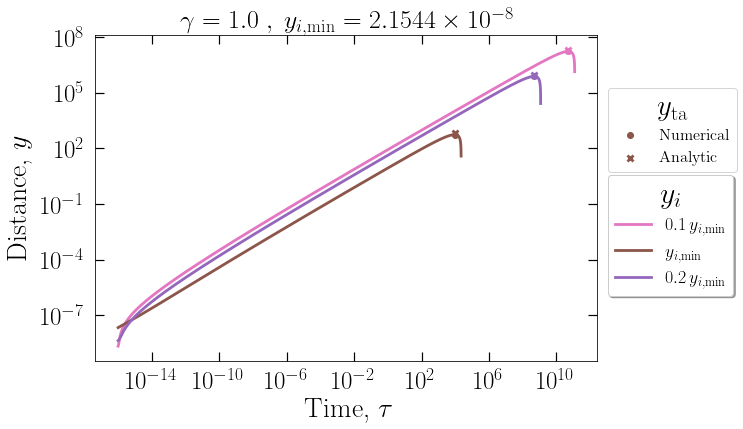

In [10]:
gamma = 1.0 
y_i_ref = 2.1544e-08
tau_i, tau_f = 1e-16, 1e15
gamma_values = np.geomspace(1e-10, 1, 5)  
yi_arr = np.array([0.1*y_i_ref, y_i_ref, 0.2*y_i_ref])


fig, ax = plt.subplots(1, figsize = (9, 6))
plt.rc('lines', linewidth = 2.8)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')






colors = ['C6', 'C5', 'C4', 'C3', 'C2', 'C1', 'C0']
marker_handles = []
for i, (y_i, color) in enumerate(zip(yi_arr, colors)):
    v_i = y_i/(2 * tau_i) 
    y0 = [y_i, v_i]
    tau_arr = np.geomspace(tau_i, tau_f, 10000) 

    
    sol_fdm = solve_ivp(j_fdm, [tau_i, tau_f], y0, args=(gamma,), t_eval=tau_arr, method='RK45',
        rtol=1e-5, atol=1e-5, events=[event_y_max, event_y_min])

    
    ax.loglog(sol_fdm.t, sol_fdm.y[0], color=color) #, label=f' ${y_i:.1e}$'

    
    if len(sol_fdm.t_events[0]) > 0: 
        tauta_numerical = sol_fdm.t_events[0][0]
        yta_numerical = sol_fdm.y_events[0][0][0]
        yta_analytic = r_turnaround_full(tauta_numerical, gamma)
        print( "y_i =", '%0.4e'%y_i , ",",  "tau_ta_numerical =", '%0.4e'%tauta_numerical, ",", "yta_numerical =", '%0.4e'%yta_numerical, ",", "yta_analytic =", '%0.4e'%yta_analytic)
            
        yta_numerical_marker = ax.scatter(tauta_numerical, yta_numerical,color=color, zorder=1  )
        yta_analytic_marker = ax.scatter(tauta_numerical, yta_analytic, color=color,  marker='x',  zorder=9)
        if i == 1:
            marker_handles.append((yta_numerical_marker, "Numerical "))
            marker_handles.append((yta_analytic_marker, "Analytic"))

if len(marker_handles) == 2:  
    legend1 = plt.legend(
        handles=[marker_handles[0][0], marker_handles[1][0]],
        labels=[marker_handles[0][1], marker_handles[1][1]],prop={'size':16.2},
        loc=(1.02, 0.58), title=r'$y_\mathrm{ta}$', title_fontsize= 29, fontsize=12)
    ax.add_artist(legend1)


lines = ax.get_lines()
legend2 = plt.legend([lines[i] for i in [0, 1, 2]], [r"$0.1 \,  y_{i, \mathrm{min}}$", r"$y_{i, \mathrm{min}}$", 
                      r"$0.2 \, y_{i, \mathrm{min}}$"], prop={'size':18}, 
                     loc=(1.02, 0.2), shadow=True, title='$y_{i}$', title_fontsize= 30,
    facecolor='white', fontsize=12)

ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)


#plt.text(tau_i, 1e-4, r'$\gamma = 3.6\times 10^{-5}$', fontsize = 25)
#plt.text(tau_i, 1e-6, r'$\tau_i = 10^{-28}$', fontsize = 25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel(r'Time, $\tau$', fontsize=28)
plt.ylabel('Distance, $y$', fontsize=28, labelpad=9)
plt.title(r'$\gamma = 1.0\; , \; y_{i, \mathrm{min}} = 2.1544\times 10^{-8}$', fontsize= 26)
plt.savefig('yta_min6.pdf', bbox_inches='tight')

plt.show()

In [9]:
# with spacings y_i = [1e-2.y_i_min_ref , yi_min_ref, 2e-2.yi_min_ref]

y_i = 7.7426e-13 , tau_ta_numerical = 9.4371e+00 , yta_numerical = 5.6838e+00 , yta_analytic = 7.0889e+00
y_i = 7.7426e-11 , tau_ta_numerical = 6.2099e-15 , yta_numerical = 4.0056e-10 , yta_analytic = 5.1848e-10
y_i = 1.5485e-12 , tau_ta_numerical = 5.2633e-02 , yta_numerical = 1.7827e-01 , yta_analytic = 2.2294e-01


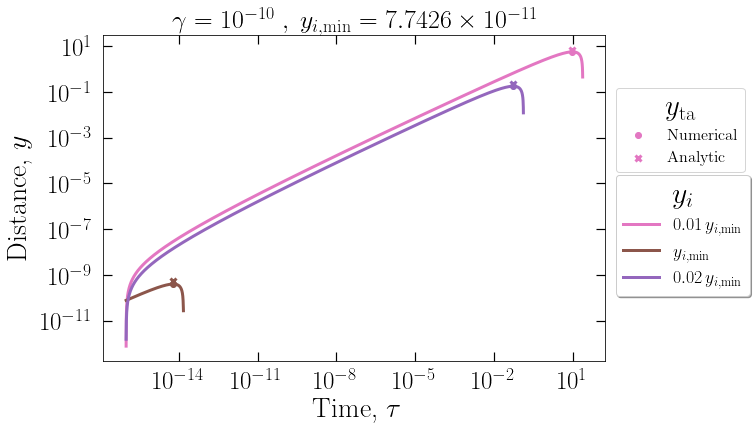

In [16]:
gamma = 1e-10
y_i_ref = 7.7426e-11
tau_i, tau_f = 1e-16, 1e15
gamma_values = np.geomspace(1e-10, 1, 5)  
yi_arr = np.array([0.01*y_i_ref, y_i_ref, 0.02*y_i_ref])


fig, ax = plt.subplots(1, figsize = (9, 6))
plt.rc('lines', linewidth = 3)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')






colors = ['C6', 'C5', 'C4', 'C3', 'C2', 'C1', 'C0']
marker_handles = []
for i, (y_i, color) in enumerate(zip(yi_arr, colors)):
    v_i = y_i/(2 * tau_i) 
    y0 = [y_i, v_i]
    tau_arr = np.geomspace(tau_i, tau_f, 10000) 

    
    sol_fdm = solve_ivp(j_fdm, [tau_i, tau_f], y0, args=(gamma,), t_eval=tau_arr, method='RK45',
        rtol=1e-5, atol=1e-5, events=[event_y_max, event_y_min])

    
    ax.loglog(sol_fdm.t, sol_fdm.y[0], color=color) #, label=f' ${y_i:.1e}$'

    
    if len(sol_fdm.t_events[0]) > 0: 
        tauta_numerical = sol_fdm.t_events[0][0]
        yta_numerical = sol_fdm.y_events[0][0][0]
        yta_analytic = r_turnaround_full(tauta_numerical, gamma)
        print( "y_i =", '%0.4e'%y_i , ",",  "tau_ta_numerical =", '%0.4e'%tauta_numerical, ",", "yta_numerical =", '%0.4e'%yta_numerical, ",", "yta_analytic =", '%0.4e'%yta_analytic)
            
        yta_numerical_marker = ax.scatter(tauta_numerical, yta_numerical,color=color, zorder=1  )
        yta_analytic_marker = ax.scatter(tauta_numerical, yta_analytic, color=color,  marker='x',  zorder=9)
        if i == 0:
            marker_handles.append((yta_numerical_marker, "Numerical "))
            marker_handles.append((yta_analytic_marker, "Analytic"))

if len(marker_handles) == 2:  
    legend1 = plt.legend(
        handles=[marker_handles[0][0], marker_handles[1][0]],
        labels=[marker_handles[0][1], marker_handles[1][1]],prop={'size':16.2},
        loc=(1.02, 0.58), title=r'$y_\mathrm{ta}$', title_fontsize= 29, fontsize=12)
    ax.add_artist(legend1)


lines = ax.get_lines()
legend2 = plt.legend([lines[i] for i in [0, 1, 2]], [r"$0.01 \,  y_{i, \mathrm{min}}$", r"$y_{i, \mathrm{min}}$", 
                      r"$0.02 \, y_{i, \mathrm{min}}$"], prop={'size':18}, 
                     loc=(1.02, 0.2), shadow=True, title='$y_{i}$', title_fontsize= 30,
    facecolor='white', fontsize=12)


ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)


#plt.text(tau_i, 1e-4, r'$\gamma = 3.6\times 10^{-5}$', fontsize = 25)
#plt.text(tau_i, 1e-6, r'$\tau_i = 10^{-28}$', fontsize = 25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel(r'Time, $\tau$', fontsize=28)
plt.ylabel('Distance, $y$', fontsize=28, labelpad=9)
plt.title(r'$\gamma = 10^{-10}\; , \; y_{i, \mathrm{min}} = 7.7426 \times 10^{-11}$', fontsize= 26)
plt.savefig('yta_min7.pdf', bbox_inches='tight')

plt.show()

y_i = 1.2915e-11 , tau_ta_numerical = 2.5134e-01 , yta_numerical = 5.0600e-01 , yta_analytic = 6.3222e-01
y_i = 1.2915e-09 , tau_ta_numerical = 3.4176e-08 , yta_numerical = 1.3642e-05 , yta_analytic = 1.6716e-05
y_i = 2.5830e-11 , tau_ta_numerical = 1.3269e-03 , yta_numerical = 1.5291e-02 , yta_analytic = 1.9168e-02


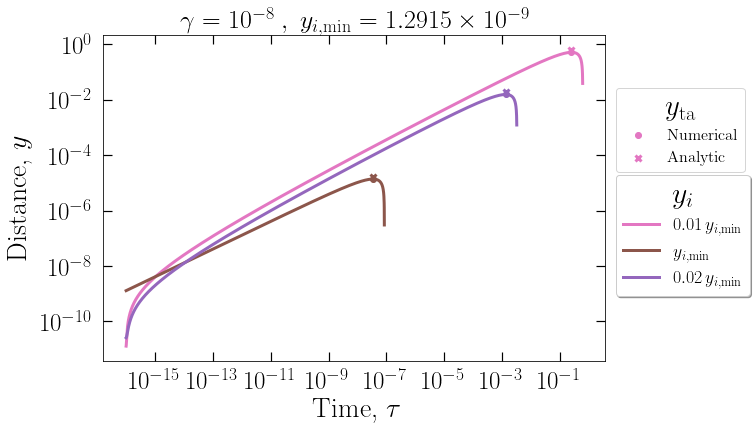

In [17]:
gamma = 1.0e-08
y_i_ref = 1.2915e-09
tau_i, tau_f = 1e-16, 1e15
gamma_values = np.geomspace(1e-10, 1, 5)  
yi_arr = np.array([0.01*y_i_ref, y_i_ref, 0.02*y_i_ref])


fig, ax = plt.subplots(1, figsize = (9, 6))
plt.rc('lines', linewidth = 3)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')






colors = ['C6', 'C5', 'C4', 'C3', 'C2', 'C1', 'C0']
marker_handles = []
for i, (y_i, color) in enumerate(zip(yi_arr, colors)):
    v_i = y_i/(2 * tau_i) 
    y0 = [y_i, v_i]
    tau_arr = np.geomspace(tau_i, tau_f, 10000) 

    
    sol_fdm = solve_ivp(j_fdm, [tau_i, tau_f], y0, args=(gamma,), t_eval=tau_arr, method='RK45',
        rtol=1e-5, atol=1e-5, events=[event_y_max, event_y_min])

    
    ax.loglog(sol_fdm.t, sol_fdm.y[0], color=color) #, label=f' ${y_i:.1e}$'

    
    if len(sol_fdm.t_events[0]) > 0: 
        tauta_numerical = sol_fdm.t_events[0][0]
        yta_numerical = sol_fdm.y_events[0][0][0]
        yta_analytic = r_turnaround_full(tauta_numerical, gamma)
        print( "y_i =", '%0.4e'%y_i , ",",  "tau_ta_numerical =", '%0.4e'%tauta_numerical, ",", "yta_numerical =", '%0.4e'%yta_numerical, ",", "yta_analytic =", '%0.4e'%yta_analytic)
            
        yta_numerical_marker = ax.scatter(tauta_numerical, yta_numerical,color=color, zorder=1  )
        yta_analytic_marker = ax.scatter(tauta_numerical, yta_analytic, color=color,  marker='x',  zorder=9)
        if i == 0:
            marker_handles.append((yta_numerical_marker, "Numerical "))
            marker_handles.append((yta_analytic_marker, "Analytic"))

if len(marker_handles) == 2:  
    legend1 = plt.legend(
        handles=[marker_handles[0][0], marker_handles[1][0]],
        labels=[marker_handles[0][1], marker_handles[1][1]],prop={'size':16.2},
        loc=(1.02, 0.58), title=r'$y_\mathrm{ta}$', title_fontsize= 29, fontsize=12)
    ax.add_artist(legend1)


lines = ax.get_lines()
legend2 = plt.legend([lines[i] for i in [0, 1, 2]], [r"$0.01 \,  y_{i, \mathrm{min}}$", r"$y_{i, \mathrm{min}}$", 
                      r"$0.02 \, y_{i, \mathrm{min}}$"], prop={'size':18}, 
                     loc=(1.02, 0.2), shadow=True, title='$y_{i}$', title_fontsize= 30,
    facecolor='white', fontsize=12)

ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)


#plt.text(tau_i, 1e-4, r'$\gamma = 3.6\times 10^{-5}$', fontsize = 25)
#plt.text(tau_i, 1e-6, r'$\tau_i = 10^{-28}$', fontsize = 25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel(r'Time, $\tau$', fontsize=28)
plt.ylabel('Distance, $y$', fontsize=28, labelpad=9)
plt.title(r'$\gamma = 10^{-8}\; , \; y_{i, \mathrm{min}} = 1.2915 \times 10^{-9}$', fontsize= 26)
plt.savefig('yta_min8.pdf', bbox_inches='tight')

plt.show()

y_i = 1.2915e-11 , tau_ta_numerical = 2.8720e+06 , yta_numerical = 2.5827e+04 , yta_analytic = 3.2073e+04
y_i = 1.2915e-09 , tau_ta_numerical = 1.5813e-07 , yta_numerical = 3.7166e-05 , yta_analytic = 4.6250e-05
y_i = 2.5830e-11 , tau_ta_numerical = 2.4310e+04 , yta_numerical = 1.0712e+03 , yta_analytic = 1.3321e+03


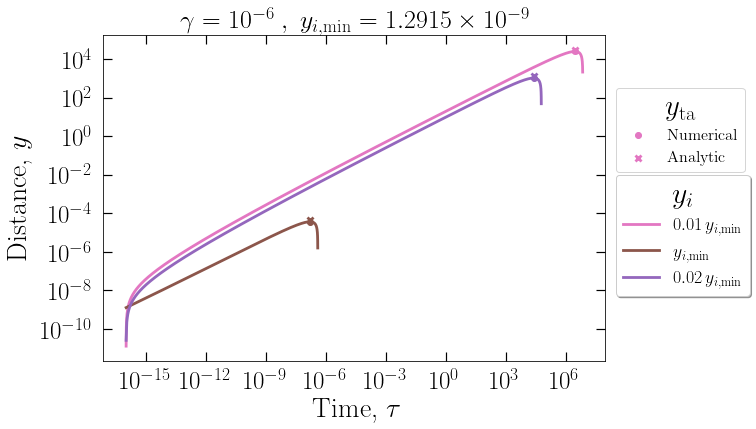

In [18]:
gamma = 1.0e-06
y_i_ref = 1.2915e-09
tau_i, tau_f = 1e-16, 1e15
gamma_values = np.geomspace(1e-10, 1, 5)  
yi_arr = np.array([0.01*y_i_ref, y_i_ref, 0.02*y_i_ref])


fig, ax = plt.subplots(1, figsize = (9, 6))
plt.rc('lines', linewidth = 2.8)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')






colors = ['C6', 'C5', 'C4', 'C3', 'C2', 'C1', 'C0']
marker_handles = []
for i, (y_i, color) in enumerate(zip(yi_arr, colors)):
    v_i = y_i/(2 * tau_i) 
    y0 = [y_i, v_i]
    tau_arr = np.geomspace(tau_i, tau_f, 10000) 

    
    sol_fdm = solve_ivp(j_fdm, [tau_i, tau_f], y0, args=(gamma,), t_eval=tau_arr, method='RK45',
        rtol=1e-5, atol=1e-5, events=[event_y_max, event_y_min])

    
    ax.loglog(sol_fdm.t, sol_fdm.y[0], color=color) #, label=f' ${y_i:.1e}$'

    
    if len(sol_fdm.t_events[0]) > 0: 
        tauta_numerical = sol_fdm.t_events[0][0]
        yta_numerical = sol_fdm.y_events[0][0][0]
        yta_analytic = r_turnaround_full(tauta_numerical, gamma)
        print( "y_i =", '%0.4e'%y_i , ",",  "tau_ta_numerical =", '%0.4e'%tauta_numerical, ",", "yta_numerical =", '%0.4e'%yta_numerical, ",", "yta_analytic =", '%0.4e'%yta_analytic)
            
        yta_numerical_marker = ax.scatter(tauta_numerical, yta_numerical,color=color, zorder=1  )
        yta_analytic_marker = ax.scatter(tauta_numerical, yta_analytic, color=color,  marker='x',  zorder=9)
        if i == 0:
            marker_handles.append((yta_numerical_marker, "Numerical "))
            marker_handles.append((yta_analytic_marker, "Analytic"))

if len(marker_handles) == 2:  
    legend1 = plt.legend(
        handles=[marker_handles[0][0], marker_handles[1][0]],
        labels=[marker_handles[0][1], marker_handles[1][1]],prop={'size':16.2},
        loc=(1.02, 0.58), title=r'$y_\mathrm{ta}$', title_fontsize= 29, fontsize=12)
    ax.add_artist(legend1)


lines = ax.get_lines()
legend2 = plt.legend([lines[i] for i in [0, 1, 2]], [r"$0.01 \,  y_{i, \mathrm{min}}$", r"$y_{i, \mathrm{min}}$", 
                      r"$0.02 \, y_{i, \mathrm{min}}$"], prop={'size':18}, 
                     loc=(1.02, 0.2), shadow=True, title='$y_{i}$', title_fontsize= 30,
    facecolor='white', fontsize=12)

ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)


#plt.text(tau_i, 1e-4, r'$\gamma = 3.6\times 10^{-5}$', fontsize = 25)
#plt.text(tau_i, 1e-6, r'$\tau_i = 10^{-28}$', fontsize = 25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel(r'Time, $\tau$', fontsize=28)
plt.ylabel('Distance, $y$', fontsize=28, labelpad=9)
plt.title(r'$\gamma = 10^{-6}\; , \; y_{i, \mathrm{min}} = 1.2915 \times 10^{-9}$', fontsize= 26)
plt.savefig('yta_min9.pdf', bbox_inches='tight')

plt.show()

y_i = 1.2915e-11 , tau_ta_numerical = 1.4747e+13 , yta_numerical = 7.7105e+08 , yta_analytic = 9.5460e+08
y_i = 1.2915e-09 , tau_ta_numerical = 2.5592e-01 , yta_numerical = 5.1215e-01 , yta_analytic = 6.3985e-01
y_i = 2.5830e-11 , tau_ta_numerical = 1.4812e+11 , yta_numerical = 3.5866e+07 , yta_analytic = 4.4439e+07


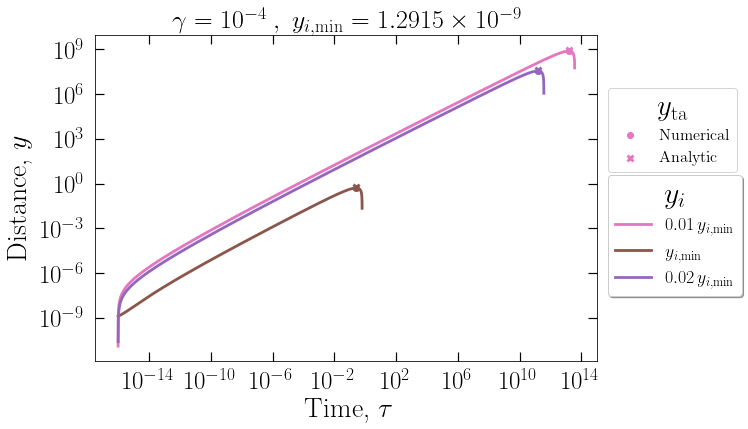

In [19]:
gamma = 1.0e-04
y_i_ref = 1.2915e-09
tau_i, tau_f = 1e-16, 1e15
gamma_values = np.geomspace(1e-10, 1, 5)  
yi_arr = np.array([0.01*y_i_ref, y_i_ref, 0.02*y_i_ref])


fig, ax = plt.subplots(1, figsize = (9, 6))
plt.rc('lines', linewidth = 2.8)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')






colors = ['C6', 'C5', 'C4', 'C3', 'C2', 'C1', 'C0']
marker_handles = []
for i, (y_i, color) in enumerate(zip(yi_arr, colors)):
    v_i = y_i/(2 * tau_i) 
    y0 = [y_i, v_i]
    tau_arr = np.geomspace(tau_i, tau_f, 10000) 

    
    sol_fdm = solve_ivp(j_fdm, [tau_i, tau_f], y0, args=(gamma,), t_eval=tau_arr, method='RK45',
        rtol=1e-5, atol=1e-5, events=[event_y_max, event_y_min])

    
    ax.loglog(sol_fdm.t, sol_fdm.y[0], color=color) #, label=f' ${y_i:.1e}$'

    
    if len(sol_fdm.t_events[0]) > 0: 
        tauta_numerical = sol_fdm.t_events[0][0]
        yta_numerical = sol_fdm.y_events[0][0][0]
        yta_analytic = r_turnaround_full(tauta_numerical, gamma)
        print( "y_i =", '%0.4e'%y_i , ",",  "tau_ta_numerical =", '%0.4e'%tauta_numerical, ",", "yta_numerical =", '%0.4e'%yta_numerical, ",", "yta_analytic =", '%0.4e'%yta_analytic)
            
        yta_numerical_marker = ax.scatter(tauta_numerical, yta_numerical,color=color, zorder=1  )
        yta_analytic_marker = ax.scatter(tauta_numerical, yta_analytic, color=color,  marker='x',  zorder=9)
        if i == 0:
            marker_handles.append((yta_numerical_marker, "Numerical "))
            marker_handles.append((yta_analytic_marker, "Analytic"))

if len(marker_handles) == 2:  
    legend1 = plt.legend(
        handles=[marker_handles[0][0], marker_handles[1][0]],
        labels=[marker_handles[0][1], marker_handles[1][1]],prop={'size':16.2},
        loc=(1.02, 0.58), title=r'$y_\mathrm{ta}$', title_fontsize= 29, fontsize=12)
    ax.add_artist(legend1)


lines = ax.get_lines()
legend2 = plt.legend([lines[i] for i in [0, 1, 2]], [r"$0.01 \,  y_{i, \mathrm{min}}$", r"$y_{i, \mathrm{min}}$", 
                      r"$0.02 \, y_{i, \mathrm{min}}$"], prop={'size':18}, 
                     loc=(1.02, 0.2), shadow=True, title='$y_{i}$', title_fontsize= 30,
    facecolor='white', fontsize=12)

ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)


#plt.text(tau_i, 1e-4, r'$\gamma = 3.6\times 10^{-5}$', fontsize = 25)
#plt.text(tau_i, 1e-6, r'$\tau_i = 10^{-28}$', fontsize = 25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel(r'Time, $\tau$', fontsize=28)
plt.ylabel('Distance, $y$', fontsize=28, labelpad=9)
plt.title(r'$\gamma = 10^{-4}\; , \; y_{i, \mathrm{min}} = 1.2915 \times 10^{-9}$', fontsize= 26)
plt.savefig('yta_min10.pdf', bbox_inches='tight')

plt.show()

y_i = 2.1544e-10 , tau_ta_numerical = 4.8733e+11 , yta_numerical = 7.9358e+07 , yta_analytic = 9.8303e+07
y_i = 2.1544e-08 , tau_ta_numerical = 1.5426e+00 , yta_numerical = 1.7204e+00 , yta_analytic = 2.1176e+00
y_i = 4.3088e-10 , tau_ta_numerical = 4.7575e+09 , yta_numerical = 3.6218e+06 , yta_analytic = 4.4903e+06


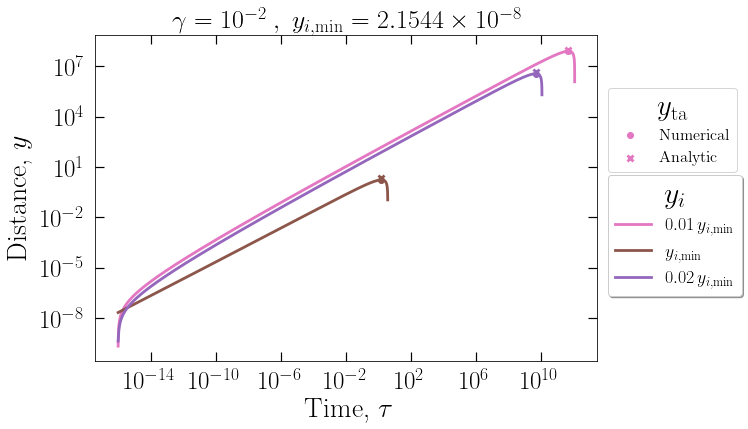

In [20]:
gamma = 1.0e-02 
y_i_ref = 2.1544e-08
tau_i, tau_f = 1e-16, 1e15
gamma_values = np.geomspace(1e-10, 1, 5)  
yi_arr = np.array([0.01*y_i_ref, y_i_ref, 0.02*y_i_ref])


fig, ax = plt.subplots(1, figsize = (9, 6))
plt.rc('lines', linewidth = 2.8)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')






colors = ['C6', 'C5', 'C4', 'C3', 'C2', 'C1', 'C0']
marker_handles = []
for i, (y_i, color) in enumerate(zip(yi_arr, colors)):
    v_i = y_i/(2 * tau_i) 
    y0 = [y_i, v_i]
    tau_arr = np.geomspace(tau_i, tau_f, 10000) 

    
    sol_fdm = solve_ivp(j_fdm, [tau_i, tau_f], y0, args=(gamma,), t_eval=tau_arr, method='RK45',
        rtol=1e-5, atol=1e-5, events=[event_y_max, event_y_min])

    
    ax.loglog(sol_fdm.t, sol_fdm.y[0], color=color) #, label=f' ${y_i:.1e}$'

    
    if len(sol_fdm.t_events[0]) > 0: 
        tauta_numerical = sol_fdm.t_events[0][0]
        yta_numerical = sol_fdm.y_events[0][0][0]
        yta_analytic = r_turnaround_full(tauta_numerical, gamma)
        print( "y_i =", '%0.4e'%y_i , ",",  "tau_ta_numerical =", '%0.4e'%tauta_numerical, ",", "yta_numerical =", '%0.4e'%yta_numerical, ",", "yta_analytic =", '%0.4e'%yta_analytic)
            
        yta_numerical_marker = ax.scatter(tauta_numerical, yta_numerical,color=color, zorder=1  )
        yta_analytic_marker = ax.scatter(tauta_numerical, yta_analytic, color=color,  marker='x',  zorder=9)
        if i == 0:
            marker_handles.append((yta_numerical_marker, "Numerical "))
            marker_handles.append((yta_analytic_marker, "Analytic"))

if len(marker_handles) == 2:  
    legend1 = plt.legend(
        handles=[marker_handles[0][0], marker_handles[1][0]],
        labels=[marker_handles[0][1], marker_handles[1][1]],prop={'size':16.2},
        loc=(1.02, 0.58), title=r'$y_\mathrm{ta}$', title_fontsize= 29, fontsize=12)
    ax.add_artist(legend1)


lines = ax.get_lines()
legend2 = plt.legend([lines[i] for i in [0, 1, 2]], [r"$0.01 \,  y_{i, \mathrm{min}}$", r"$y_{i, \mathrm{min}}$", 
                      r"$0.02 \, y_{i, \mathrm{min}}$"], prop={'size':18}, 
                     loc=(1.02, 0.2), shadow=True, title='$y_{i}$', title_fontsize= 30,
    facecolor='white', fontsize=12)

ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)


#plt.text(tau_i, 1e-4, r'$\gamma = 3.6\times 10^{-5}$', fontsize = 25)
#plt.text(tau_i, 1e-6, r'$\tau_i = 10^{-28}$', fontsize = 25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel(r'Time, $\tau$', fontsize=28)
plt.ylabel('Distance, $y$', fontsize=28, labelpad=9)
plt.title(r'$\gamma = 10^{-2}\; , \; y_{i, \mathrm{min}} = 2.1544\times 10^{-8}$', fontsize= 26)
plt.savefig('yta_min11.pdf', bbox_inches='tight')

plt.show()

y_i = 2.1544e-08 , tau_ta_numerical = 9.0318e+03 , yta_numerical = 5.5367e+02 , yta_analytic = 6.8836e+02


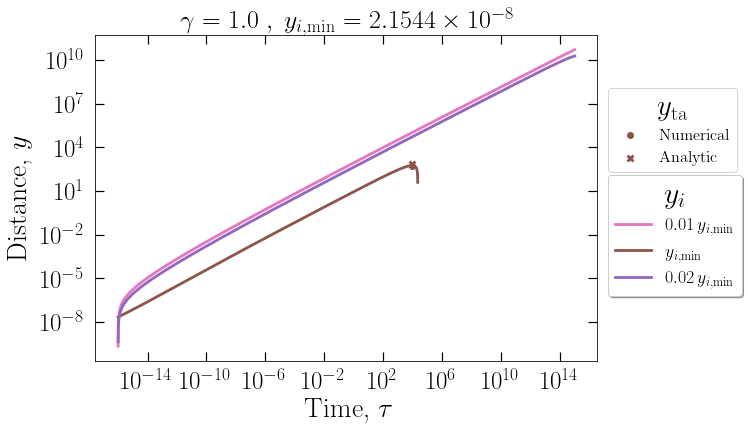

In [21]:
gamma = 1.0 
y_i_ref = 2.1544e-08
tau_i, tau_f = 1e-16, 1e15
gamma_values = np.geomspace(1e-10, 1, 5)  
yi_arr = np.array([0.01*y_i_ref, y_i_ref, 0.02*y_i_ref])


fig, ax = plt.subplots(1, figsize = (9, 6))
plt.rc('lines', linewidth = 2.8)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')






colors = ['C6', 'C5', 'C4', 'C3', 'C2', 'C1', 'C0']
marker_handles = []
for i, (y_i, color) in enumerate(zip(yi_arr, colors)):
    v_i = y_i/(2 * tau_i) 
    y0 = [y_i, v_i]
    tau_arr = np.geomspace(tau_i, tau_f, 10000) 

    
    sol_fdm = solve_ivp(j_fdm, [tau_i, tau_f], y0, args=(gamma,), t_eval=tau_arr, method='RK45',
        rtol=1e-5, atol=1e-5, events=[event_y_max, event_y_min])

    
    ax.loglog(sol_fdm.t, sol_fdm.y[0], color=color) #, label=f' ${y_i:.1e}$'

    
    if len(sol_fdm.t_events[0]) > 0: 
        tauta_numerical = sol_fdm.t_events[0][0]
        yta_numerical = sol_fdm.y_events[0][0][0]
        yta_analytic = r_turnaround_full(tauta_numerical, gamma)
        print( "y_i =", '%0.4e'%y_i , ",",  "tau_ta_numerical =", '%0.4e'%tauta_numerical, ",", "yta_numerical =", '%0.4e'%yta_numerical, ",", "yta_analytic =", '%0.4e'%yta_analytic)
            
        yta_numerical_marker = ax.scatter(tauta_numerical, yta_numerical,color=color, zorder=1  )
        yta_analytic_marker = ax.scatter(tauta_numerical, yta_analytic, color=color,  marker='x',  zorder=9)
        if i == 1:
            marker_handles.append((yta_numerical_marker, "Numerical "))
            marker_handles.append((yta_analytic_marker, "Analytic"))

if len(marker_handles) == 2:  
    legend1 = plt.legend(
        handles=[marker_handles[0][0], marker_handles[1][0]],
        labels=[marker_handles[0][1], marker_handles[1][1]],prop={'size':16.2},
        loc=(1.02, 0.58), title=r'$y_\mathrm{ta}$', title_fontsize= 29, fontsize=12)
    ax.add_artist(legend1)


lines = ax.get_lines()
legend2 = plt.legend([lines[i] for i in [0, 1, 2]], [r"$0.01 \,  y_{i, \mathrm{min}}$", r"$y_{i, \mathrm{min}}$", 
                      r"$0.02 \, y_{i, \mathrm{min}}$"], prop={'size':18}, 
                     loc=(1.02, 0.2), shadow=True, title='$y_{i}$', title_fontsize= 30,
    facecolor='white', fontsize=12)

ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)


#plt.text(tau_i, 1e-4, r'$\gamma = 3.6\times 10^{-5}$', fontsize = 25)
#plt.text(tau_i, 1e-6, r'$\tau_i = 10^{-28}$', fontsize = 25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel(r'Time, $\tau$', fontsize=28)
plt.ylabel('Distance, $y$', fontsize=28, labelpad=9)
plt.title(r'$\gamma = 1.0\; , \; y_{i, \mathrm{min}} = 2.1544\times 10^{-8}$', fontsize= 26)
plt.savefig('yta_min12.pdf', bbox_inches='tight')

plt.show()

In [22]:
# with spacings y_i = [1e-3.y_i_min_ref , yi_min_ref, 2e-3.yi_min_ref]

y_i = 7.7426e-14 , tau_ta_numerical = 9.2250e+07 , yta_numerical = 2.6118e+05 , yta_analytic = 3.2409e+05
y_i = 7.7426e-11 , tau_ta_numerical = 6.2099e-15 , yta_numerical = 4.0056e-10 , yta_analytic = 5.1848e-10
y_i = 1.5485e-13 , tau_ta_numerical = 8.1144e+05 , yta_numerical = 1.1116e+04 , yta_analytic = 1.3810e+04


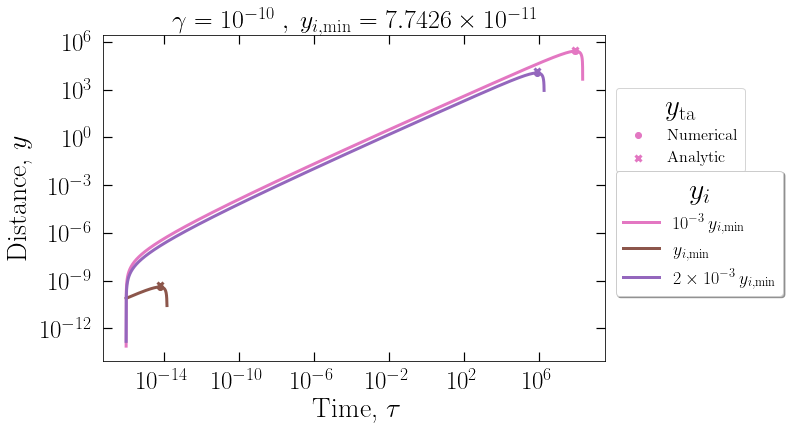

In [24]:
gamma = 1e-10
y_i_ref = 7.7426e-11
tau_i, tau_f = 1e-16, 1e15
gamma_values = np.geomspace(1e-10, 1, 5)  
yi_arr = np.array([0.001*y_i_ref, y_i_ref, 0.002*y_i_ref])


fig, ax = plt.subplots(1, figsize = (9, 6))
plt.rc('lines', linewidth = 3)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')






colors = ['C6', 'C5', 'C4', 'C3', 'C2', 'C1', 'C0']
marker_handles = []
for i, (y_i, color) in enumerate(zip(yi_arr, colors)):
    v_i = y_i/(2 * tau_i) 
    y0 = [y_i, v_i]
    tau_arr = np.geomspace(tau_i, tau_f, 10000) 

    
    sol_fdm = solve_ivp(j_fdm, [tau_i, tau_f], y0, args=(gamma,), t_eval=tau_arr, method='RK45',
        rtol=1e-5, atol=1e-5, events=[event_y_max, event_y_min])

    
    ax.loglog(sol_fdm.t, sol_fdm.y[0], color=color) #, label=f' ${y_i:.1e}$'

    
    if len(sol_fdm.t_events[0]) > 0: 
        tauta_numerical = sol_fdm.t_events[0][0]
        yta_numerical = sol_fdm.y_events[0][0][0]
        yta_analytic = r_turnaround_full(tauta_numerical, gamma)
        print( "y_i =", '%0.4e'%y_i , ",",  "tau_ta_numerical =", '%0.4e'%tauta_numerical, ",", "yta_numerical =", '%0.4e'%yta_numerical, ",", "yta_analytic =", '%0.4e'%yta_analytic)
            
        yta_numerical_marker = ax.scatter(tauta_numerical, yta_numerical,color=color, zorder=1  )
        yta_analytic_marker = ax.scatter(tauta_numerical, yta_analytic, color=color,  marker='x',  zorder=9)
        if i == 0:
            marker_handles.append((yta_numerical_marker, "Numerical "))
            marker_handles.append((yta_analytic_marker, "Analytic"))

if len(marker_handles) == 2:  
    legend1 = plt.legend(
        handles=[marker_handles[0][0], marker_handles[1][0]],
        labels=[marker_handles[0][1], marker_handles[1][1]],prop={'size':16.2},
        loc=(1.02, 0.58), title=r'$y_\mathrm{ta}$', title_fontsize= 29, fontsize=12)
    ax.add_artist(legend1)


lines = ax.get_lines()
legend2 = plt.legend([lines[i] for i in [0, 1, 2]], [r"$10^{-3} \,  y_{i, \mathrm{min}}$", r"$y_{i, \mathrm{min}}$", 
                      r"$2\times 10^{-3} \, y_{i, \mathrm{min}}$"], prop={'size':18}, 
                     loc=(1.02, 0.2), shadow=True, title='$y_{i}$', title_fontsize= 30,
    facecolor='white', fontsize=12)


ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)


#plt.text(tau_i, 1e-4, r'$\gamma = 3.6\times 10^{-5}$', fontsize = 25)
#plt.text(tau_i, 1e-6, r'$\tau_i = 10^{-28}$', fontsize = 25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel(r'Time, $\tau$', fontsize=28)
plt.ylabel('Distance, $y$', fontsize=28, labelpad=9)
plt.title(r'$\gamma = 10^{-10}\; , \; y_{i, \mathrm{min}} = 7.7426 \times 10^{-11}$', fontsize= 26)
plt.savefig('yta_min13.pdf', bbox_inches='tight')

plt.show()

y_i = 1.2915e-12 , tau_ta_numerical = 2.8676e+06 , yta_numerical = 2.5800e+04 , yta_analytic = 3.2041e+04
y_i = 1.2915e-09 , tau_ta_numerical = 3.4176e-08 , yta_numerical = 1.3642e-05 , yta_analytic = 1.6716e-05
y_i = 2.5830e-12 , tau_ta_numerical = 2.4234e+04 , yta_numerical = 1.0690e+03 , yta_analytic = 1.3293e+03


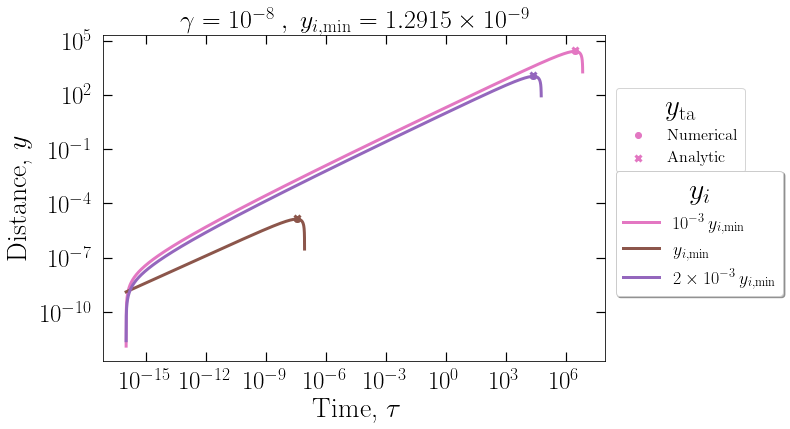

In [25]:
gamma = 1.0e-08
y_i_ref = 1.2915e-09
tau_i, tau_f = 1e-16, 1e15
gamma_values = np.geomspace(1e-10, 1, 5)  
yi_arr = np.array([0.001*y_i_ref, y_i_ref, 0.002*y_i_ref])


fig, ax = plt.subplots(1, figsize = (9, 6))
plt.rc('lines', linewidth = 3)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')






colors = ['C6', 'C5', 'C4', 'C3', 'C2', 'C1', 'C0']
marker_handles = []
for i, (y_i, color) in enumerate(zip(yi_arr, colors)):
    v_i = y_i/(2 * tau_i) 
    y0 = [y_i, v_i]
    tau_arr = np.geomspace(tau_i, tau_f, 10000) 

    
    sol_fdm = solve_ivp(j_fdm, [tau_i, tau_f], y0, args=(gamma,), t_eval=tau_arr, method='RK45',
        rtol=1e-5, atol=1e-5, events=[event_y_max, event_y_min])

    
    ax.loglog(sol_fdm.t, sol_fdm.y[0], color=color) #, label=f' ${y_i:.1e}$'

    
    if len(sol_fdm.t_events[0]) > 0: 
        tauta_numerical = sol_fdm.t_events[0][0]
        yta_numerical = sol_fdm.y_events[0][0][0]
        yta_analytic = r_turnaround_full(tauta_numerical, gamma)
        print( "y_i =", '%0.4e'%y_i , ",",  "tau_ta_numerical =", '%0.4e'%tauta_numerical, ",", "yta_numerical =", '%0.4e'%yta_numerical, ",", "yta_analytic =", '%0.4e'%yta_analytic)
            
        yta_numerical_marker = ax.scatter(tauta_numerical, yta_numerical,color=color, zorder=1  )
        yta_analytic_marker = ax.scatter(tauta_numerical, yta_analytic, color=color,  marker='x',  zorder=9)
        if i == 0:
            marker_handles.append((yta_numerical_marker, "Numerical "))
            marker_handles.append((yta_analytic_marker, "Analytic"))

if len(marker_handles) == 2:  
    legend1 = plt.legend(
        handles=[marker_handles[0][0], marker_handles[1][0]],
        labels=[marker_handles[0][1], marker_handles[1][1]],prop={'size':16.2},
        loc=(1.02, 0.58), title=r'$y_\mathrm{ta}$', title_fontsize= 29, fontsize=12)
    ax.add_artist(legend1)


lines = ax.get_lines()
legend2 = plt.legend([lines[i] for i in [0, 1, 2]], [r"$10^{-3} \,  y_{i, \mathrm{min}}$", r"$y_{i, \mathrm{min}}$", 
                      r"$2\times 10^{-3} \, y_{i, \mathrm{min}}$"], prop={'size':18}, 
                     loc=(1.02, 0.2), shadow=True, title='$y_{i}$', title_fontsize= 30,
    facecolor='white', fontsize=12)

ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)


#plt.text(tau_i, 1e-4, r'$\gamma = 3.6\times 10^{-5}$', fontsize = 25)
#plt.text(tau_i, 1e-6, r'$\tau_i = 10^{-28}$', fontsize = 25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel(r'Time, $\tau$', fontsize=28)
plt.ylabel('Distance, $y$', fontsize=28, labelpad=9)
plt.title(r'$\gamma = 10^{-8}\; , \; y_{i, \mathrm{min}} = 1.2915 \times 10^{-9}$', fontsize= 26)
plt.savefig('yta_min14.pdf', bbox_inches='tight')

plt.show()

y_i = 1.2915e-12 , tau_ta_numerical = 1.4743e+13 , yta_numerical = 7.7090e+08 , yta_analytic = 9.5441e+08
y_i = 1.2915e-09 , tau_ta_numerical = 1.5813e-07 , yta_numerical = 3.7166e-05 , yta_analytic = 4.6250e-05
y_i = 2.5830e-12 , tau_ta_numerical = 1.4816e+11 , yta_numerical = 3.5874e+07 , yta_analytic = 4.4448e+07


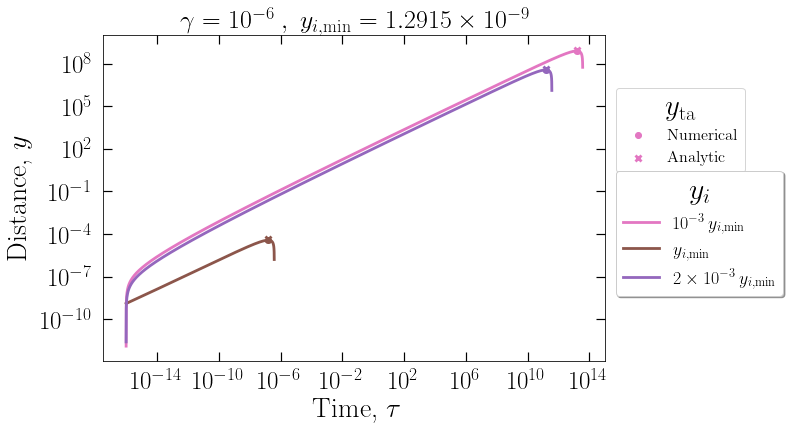

In [26]:
gamma = 1.0e-06
y_i_ref = 1.2915e-09
tau_i, tau_f = 1e-16, 1e15
gamma_values = np.geomspace(1e-10, 1, 5)  
yi_arr = np.array([0.001*y_i_ref, y_i_ref, 0.002*y_i_ref])


fig, ax = plt.subplots(1, figsize = (9, 6))
plt.rc('lines', linewidth = 2.8)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')






colors = ['C6', 'C5', 'C4', 'C3', 'C2', 'C1', 'C0']
marker_handles = []
for i, (y_i, color) in enumerate(zip(yi_arr, colors)):
    v_i = y_i/(2 * tau_i) 
    y0 = [y_i, v_i]
    tau_arr = np.geomspace(tau_i, tau_f, 10000) 

    
    sol_fdm = solve_ivp(j_fdm, [tau_i, tau_f], y0, args=(gamma,), t_eval=tau_arr, method='RK45',
        rtol=1e-5, atol=1e-5, events=[event_y_max, event_y_min])

    
    ax.loglog(sol_fdm.t, sol_fdm.y[0], color=color) #, label=f' ${y_i:.1e}$'

    
    if len(sol_fdm.t_events[0]) > 0: 
        tauta_numerical = sol_fdm.t_events[0][0]
        yta_numerical = sol_fdm.y_events[0][0][0]
        yta_analytic = r_turnaround_full(tauta_numerical, gamma)
        print( "y_i =", '%0.4e'%y_i , ",",  "tau_ta_numerical =", '%0.4e'%tauta_numerical, ",", "yta_numerical =", '%0.4e'%yta_numerical, ",", "yta_analytic =", '%0.4e'%yta_analytic)
            
        yta_numerical_marker = ax.scatter(tauta_numerical, yta_numerical,color=color, zorder=1  )
        yta_analytic_marker = ax.scatter(tauta_numerical, yta_analytic, color=color,  marker='x',  zorder=9)
        if i == 0:
            marker_handles.append((yta_numerical_marker, "Numerical "))
            marker_handles.append((yta_analytic_marker, "Analytic"))

if len(marker_handles) == 2:  
    legend1 = plt.legend(
        handles=[marker_handles[0][0], marker_handles[1][0]],
        labels=[marker_handles[0][1], marker_handles[1][1]],prop={'size':16.2},
        loc=(1.02, 0.58), title=r'$y_\mathrm{ta}$', title_fontsize= 29, fontsize=12)
    ax.add_artist(legend1)


lines = ax.get_lines()
legend2 = plt.legend([lines[i] for i in [0, 1, 2]], [r"$10^{-3} \,  y_{i, \mathrm{min}}$", r"$y_{i, \mathrm{min}}$", 
                      r"$2\times 10^{-3} \, y_{i, \mathrm{min}}$"], prop={'size':18}, 
                     loc=(1.02, 0.2), shadow=True, title='$y_{i}$', title_fontsize= 30,
    facecolor='white', fontsize=12)

ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)


#plt.text(tau_i, 1e-4, r'$\gamma = 3.6\times 10^{-5}$', fontsize = 25)
#plt.text(tau_i, 1e-6, r'$\tau_i = 10^{-28}$', fontsize = 25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel(r'Time, $\tau$', fontsize=28)
plt.ylabel('Distance, $y$', fontsize=28, labelpad=9)
plt.title(r'$\gamma = 10^{-6}\; , \; y_{i, \mathrm{min}} = 1.2915 \times 10^{-9}$', fontsize= 26)
plt.savefig('yta_min15.pdf', bbox_inches='tight')
plt.show()

y_i = 1.2915e-09 , tau_ta_numerical = 2.5592e-01 , yta_numerical = 5.1215e-01 , yta_analytic = 6.3985e-01


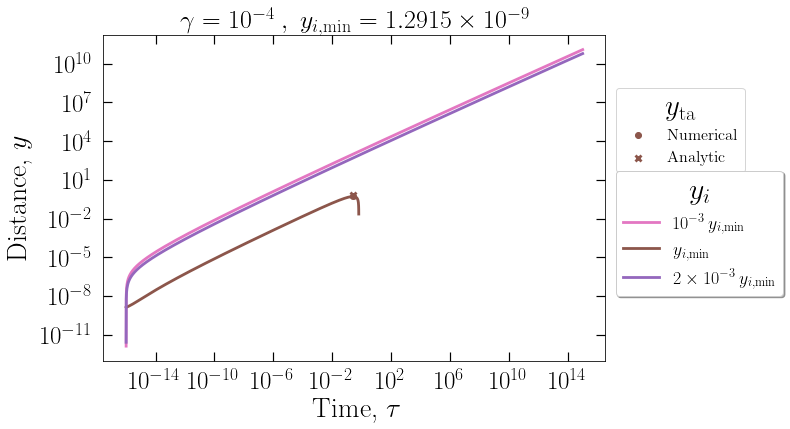

In [28]:
gamma = 1.0e-04
y_i_ref = 1.2915e-09
tau_i, tau_f = 1e-16, 1e15
gamma_values = np.geomspace(1e-10, 1, 5)  
yi_arr = np.array([0.001*y_i_ref, y_i_ref, 0.002*y_i_ref])


fig, ax = plt.subplots(1, figsize = (9, 6))
plt.rc('lines', linewidth = 2.8)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')






colors = ['C6', 'C5', 'C4', 'C3', 'C2', 'C1', 'C0']
marker_handles = []
for i, (y_i, color) in enumerate(zip(yi_arr, colors)):
    v_i = y_i/(2 * tau_i) 
    y0 = [y_i, v_i]
    tau_arr = np.geomspace(tau_i, tau_f, 10000) 

    
    sol_fdm = solve_ivp(j_fdm, [tau_i, tau_f], y0, args=(gamma,), t_eval=tau_arr, method='RK45',
        rtol=1e-5, atol=1e-5, events=[event_y_max, event_y_min])

    
    ax.loglog(sol_fdm.t, sol_fdm.y[0], color=color) #, label=f' ${y_i:.1e}$'

    
    if len(sol_fdm.t_events[0]) > 0: 
        tauta_numerical = sol_fdm.t_events[0][0]
        yta_numerical = sol_fdm.y_events[0][0][0]
        yta_analytic = r_turnaround_full(tauta_numerical, gamma)
        print( "y_i =", '%0.4e'%y_i , ",",  "tau_ta_numerical =", '%0.4e'%tauta_numerical, ",", "yta_numerical =", '%0.4e'%yta_numerical, ",", "yta_analytic =", '%0.4e'%yta_analytic)
            
        yta_numerical_marker = ax.scatter(tauta_numerical, yta_numerical,color=color, zorder=1  )
        yta_analytic_marker = ax.scatter(tauta_numerical, yta_analytic, color=color,  marker='x',  zorder=9)
        if i == 1:
            marker_handles.append((yta_numerical_marker, "Numerical "))
            marker_handles.append((yta_analytic_marker, "Analytic"))

if len(marker_handles) == 2:  
    legend1 = plt.legend(
        handles=[marker_handles[0][0], marker_handles[1][0]],
        labels=[marker_handles[0][1], marker_handles[1][1]],prop={'size':16.2},
        loc=(1.02, 0.58), title=r'$y_\mathrm{ta}$', title_fontsize= 29, fontsize=12)
    ax.add_artist(legend1)


lines = ax.get_lines()
legend2 = plt.legend([lines[i] for i in [0, 1, 2]], [r"$10^{-3} \,  y_{i, \mathrm{min}}$", r"$y_{i, \mathrm{min}}$", 
                      r"$2\times 10^{-3} \, y_{i, \mathrm{min}}$"], prop={'size':18}, 
                     loc=(1.02, 0.2), shadow=True, title='$y_{i}$', title_fontsize= 30,
    facecolor='white', fontsize=12)

ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)


#plt.text(tau_i, 1e-4, r'$\gamma = 3.6\times 10^{-5}$', fontsize = 25)
#plt.text(tau_i, 1e-6, r'$\tau_i = 10^{-28}$', fontsize = 25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel(r'Time, $\tau$', fontsize=28)
plt.ylabel('Distance, $y$', fontsize=28, labelpad=9)
plt.title(r'$\gamma = 10^{-4}\; , \; y_{i, \mathrm{min}} = 1.2915 \times 10^{-9}$', fontsize= 26)
plt.savefig('yta_min16.pdf', bbox_inches='tight')

plt.show()

y_i = 2.1544e-08 , tau_ta_numerical = 1.5426e+00 , yta_numerical = 1.7204e+00 , yta_analytic = 2.1176e+00


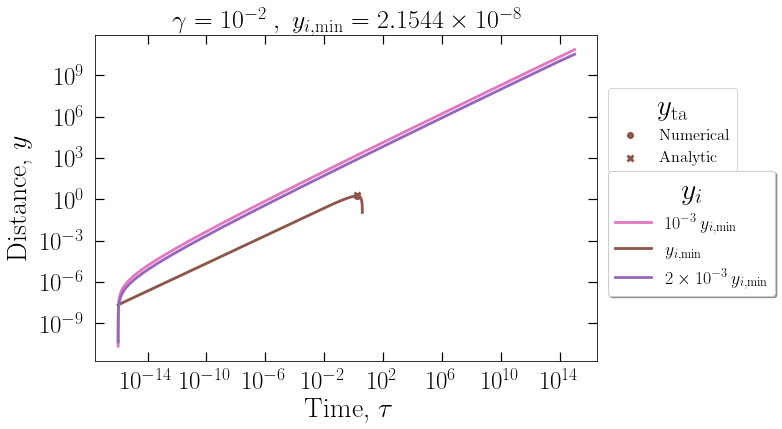

In [30]:
gamma = 1.0e-02 
y_i_ref = 2.1544e-08
tau_i, tau_f = 1e-16, 1e15
gamma_values = np.geomspace(1e-10, 1, 5)  
yi_arr = np.array([0.001*y_i_ref, y_i_ref, 0.002*y_i_ref])


fig, ax = plt.subplots(1, figsize = (9, 6))
plt.rc('lines', linewidth = 2.8)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')






colors = ['C6', 'C5', 'C4', 'C3', 'C2', 'C1', 'C0']
marker_handles = []
for i, (y_i, color) in enumerate(zip(yi_arr, colors)):
    v_i = y_i/(2 * tau_i) 
    y0 = [y_i, v_i]
    tau_arr = np.geomspace(tau_i, tau_f, 10000) 

    
    sol_fdm = solve_ivp(j_fdm, [tau_i, tau_f], y0, args=(gamma,), t_eval=tau_arr, method='RK45',
        rtol=1e-5, atol=1e-5, events=[event_y_max, event_y_min])

    
    ax.loglog(sol_fdm.t, sol_fdm.y[0], color=color) #, label=f' ${y_i:.1e}$'

    
    if len(sol_fdm.t_events[0]) > 0: 
        tauta_numerical = sol_fdm.t_events[0][0]
        yta_numerical = sol_fdm.y_events[0][0][0]
        yta_analytic = r_turnaround_full(tauta_numerical, gamma)
        print( "y_i =", '%0.4e'%y_i , ",",  "tau_ta_numerical =", '%0.4e'%tauta_numerical, ",", "yta_numerical =", '%0.4e'%yta_numerical, ",", "yta_analytic =", '%0.4e'%yta_analytic)
            
        yta_numerical_marker = ax.scatter(tauta_numerical, yta_numerical,color=color, zorder=1  )
        yta_analytic_marker = ax.scatter(tauta_numerical, yta_analytic, color=color,  marker='x',  zorder=9)
        if i == 1:
            marker_handles.append((yta_numerical_marker, "Numerical "))
            marker_handles.append((yta_analytic_marker, "Analytic"))

if len(marker_handles) == 2:  
    legend1 = plt.legend(
        handles=[marker_handles[0][0], marker_handles[1][0]],
        labels=[marker_handles[0][1], marker_handles[1][1]],prop={'size':16.2},
        loc=(1.02, 0.58), title=r'$y_\mathrm{ta}$', title_fontsize= 29, fontsize=12)
    ax.add_artist(legend1)


lines = ax.get_lines()
legend2 = plt.legend([lines[i] for i in [0, 1, 2]], [r"$10^{-3} \,  y_{i, \mathrm{min}}$", r"$y_{i, \mathrm{min}}$", 
                      r"$2\times 10^{-3} \, y_{i, \mathrm{min}}$"], prop={'size':18}, 
                     loc=(1.02, 0.2), shadow=True, title='$y_{i}$', title_fontsize= 30,
    facecolor='white', fontsize=12)

ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)


#plt.text(tau_i, 1e-4, r'$\gamma = 3.6\times 10^{-5}$', fontsize = 25)
#plt.text(tau_i, 1e-6, r'$\tau_i = 10^{-28}$', fontsize = 25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel(r'Time, $\tau$', fontsize=28)
plt.ylabel('Distance, $y$', fontsize=28, labelpad=9)
plt.title(r'$\gamma = 10^{-2}\; , \; y_{i, \mathrm{min}} = 2.1544\times 10^{-8}$', fontsize= 26)
plt.savefig('yta_min17.pdf', bbox_inches='tight')

plt.show()

y_i = 2.1544e-08 , tau_ta_numerical = 9.0318e+03 , yta_numerical = 5.5367e+02 , yta_analytic = 6.8836e+02


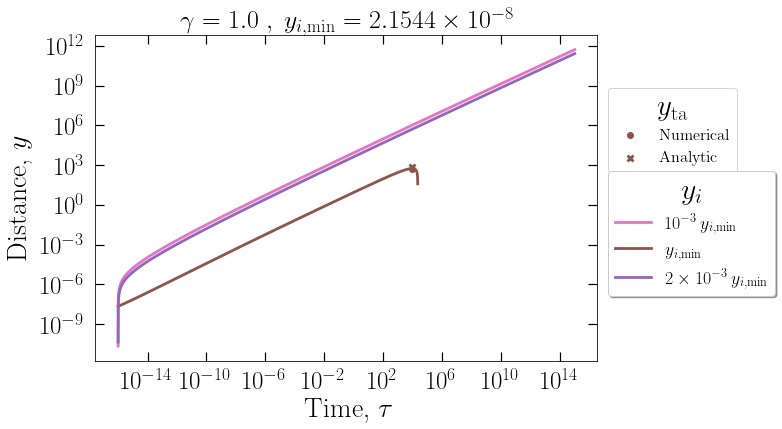

In [31]:
gamma = 1.0 
y_i_ref = 2.1544e-08
tau_i, tau_f = 1e-16, 1e15
gamma_values = np.geomspace(1e-10, 1, 5)  
yi_arr = np.array([0.001*y_i_ref, y_i_ref, 0.002*y_i_ref])


fig, ax = plt.subplots(1, figsize = (9, 6))
plt.rc('lines', linewidth = 2.8)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')






colors = ['C6', 'C5', 'C4', 'C3', 'C2', 'C1', 'C0']
marker_handles = []
for i, (y_i, color) in enumerate(zip(yi_arr, colors)):
    v_i = y_i/(2 * tau_i) 
    y0 = [y_i, v_i]
    tau_arr = np.geomspace(tau_i, tau_f, 10000) 

    
    sol_fdm = solve_ivp(j_fdm, [tau_i, tau_f], y0, args=(gamma,), t_eval=tau_arr, method='RK45',
        rtol=1e-5, atol=1e-5, events=[event_y_max, event_y_min])

    
    ax.loglog(sol_fdm.t, sol_fdm.y[0], color=color) #, label=f' ${y_i:.1e}$'

    
    if len(sol_fdm.t_events[0]) > 0: 
        tauta_numerical = sol_fdm.t_events[0][0]
        yta_numerical = sol_fdm.y_events[0][0][0]
        yta_analytic = r_turnaround_full(tauta_numerical, gamma)
        print( "y_i =", '%0.4e'%y_i , ",",  "tau_ta_numerical =", '%0.4e'%tauta_numerical, ",", "yta_numerical =", '%0.4e'%yta_numerical, ",", "yta_analytic =", '%0.4e'%yta_analytic)
            
        yta_numerical_marker = ax.scatter(tauta_numerical, yta_numerical,color=color, zorder=1  )
        yta_analytic_marker = ax.scatter(tauta_numerical, yta_analytic, color=color,  marker='x',  zorder=9)
        if i == 1:
            marker_handles.append((yta_numerical_marker, "Numerical "))
            marker_handles.append((yta_analytic_marker, "Analytic"))

if len(marker_handles) == 2:  
    legend1 = plt.legend(
        handles=[marker_handles[0][0], marker_handles[1][0]],
        labels=[marker_handles[0][1], marker_handles[1][1]],prop={'size':16.2},
        loc=(1.02, 0.58), title=r'$y_\mathrm{ta}$', title_fontsize= 29, fontsize=12)
    ax.add_artist(legend1)


lines = ax.get_lines()
legend2 = plt.legend([lines[i] for i in [0, 1, 2]], [r"$10^{-3} \,  y_{i, \mathrm{min}}$", r"$y_{i, \mathrm{min}}$", 
                      r"$2\times 10^{-3} \, y_{i, \mathrm{min}}$"], prop={'size':18}, 
                     loc=(1.02, 0.2), shadow=True, title='$y_{i}$', title_fontsize= 30,
    facecolor='white', fontsize=12)

ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)


#plt.text(tau_i, 1e-4, r'$\gamma = 3.6\times 10^{-5}$', fontsize = 25)
#plt.text(tau_i, 1e-6, r'$\tau_i = 10^{-28}$', fontsize = 25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel(r'Time, $\tau$', fontsize=28)
plt.ylabel('Distance, $y$', fontsize=28, labelpad=9)
plt.title(r'$\gamma = 1.0\; , \; y_{i, \mathrm{min}} = 2.1544\times 10^{-8}$', fontsize= 26)
plt.savefig('yta_min18.pdf', bbox_inches='tight')

plt.show()